# Sustainable Finance Project - Group 6

### Authors:
- [Alex Pinel](https://www.linkedin.com/in/alex-pinel-440513287/)
- [Anna Dovha](https://www.linkedin.com/in/anna-dovha-28b178218/)
- [Anna Perrottet](https://www.linkedin.com/in/anna-perrottet-1a2242248/)
- [Johann Gremaud](https://ch.linkedin.com/in/johann-gremaud?trk=public_profile_browsemap)


<img src="https://idbinvest.org/sites/default/files/styles/size936x656/public/2023-05/infrastructuregap_0.jpg.webp?itok=KiXfQbWS" width="650">

*Image: Getty Images/iStockphoto*  
[Accessed 25 February 2024](https://www.weforum.org/agenda/2023/09/business-climate-action-scale-up/)

## Installing and importing the necessary packages

In [280]:

# Install required packages
!pip install pandas
!pip install seaborn
!pip install numpy
!pip install cvxopt

# Import packages
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
import scipy.optimize as sco
from cvxopt import matrix, solvers
from scipy.optimize import minimize

In [281]:
# SEABORN THEME
scale = 0.4
W = 16*scale
H = 9*scale
sns.set(rc = {'figure.figsize':(W,H)})
sns.set_style("white")

## Dowloading not cleaned data from GitHub


We use the data provided in the file name "ESG scores". We download the files with the values for the market value, stock prices and the social scores

In our first step, we download the data provided in the zip folder "ESG scores". In the first file, names as "Static Carbon", we explore with which countries we are potentially going to work with.

In [282]:
url_market_value_month = "https://raw.githubusercontent.com/AnyaLang/Finance-Group-6/48b5f7e937226acda7c4f90ab78e372532e1b4fe/DS_MV_USD_M.xlsx"
df_market_value_month = pd.read_excel(url_market_value_month)

url_market_value_year = "https://raw.githubusercontent.com/AnyaLang/Finance-Group-6/48b5f7e937226acda7c4f90ab78e372532e1b4fe/DS_MV_USD_Y.xlsx"
df_market_value_year = pd.read_excel(url_market_value_year)

url_prices_month = "https://raw.githubusercontent.com/AnyaLang/Finance-Group-6/48b5f7e937226acda7c4f90ab78e372532e1b4fe/DS_RI_T_USD_M.xlsx"
df_prices_month = pd.read_excel(url_prices_month)

url_prices_year = "https://raw.githubusercontent.com/AnyaLang/Finance-Group-6/48b5f7e937226acda7c4f90ab78e372532e1b4fe/DS_RI_T_USD_Y.xlsx"
df_prices_year = pd.read_excel(url_prices_year)

url_social_score = "https://raw.githubusercontent.com/AnyaLang/Finance-Group-6/48b5f7e937226acda7c4f90ab78e372532e1b4fe/DS_SScore_Y.xlsx"
s_score = pd.read_excel(url_social_score)

url_risk_free_rate = "https://raw.githubusercontent.com/AnyaLang/Finance-Group-6/d4bbde59e1211889279031cbb66ae2961c5a3098/Risk_Free_Rate.xlsx"
df_risk_free_rate = pd.read_excel(url_risk_free_rate)

## Data cleaning

### Selecting countries for the EUR region

For our project, we are interesting to see, how many countries have the Social score and are based in Europe. To select these companies, we rely on the file  "Countries to Regions".

In [283]:
# List of European country codes based on the file "Countries to Regions" corresponding to the EUR region
european_country_codes = [
    'AT', 'BE', 'CH', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'IE', 'IL',
    'IT', 'NL', 'NO', 'PT', 'SE'
]

In [284]:
# Function to filter datasets based on region
def filter_by_region(df, country_codes):
    # Extract country codes from ISINs
    df['Country_Code'] = df['ISIN'].str[:2]
    # Filter based on the given country codes
    return df[df['Country_Code'].isin(country_codes)]

# Create the new dfs for the EUR

df_market_value_month_eur = filter_by_region(df_market_value_month, european_country_codes)
df_market_value_year_eur = filter_by_region(df_market_value_year, european_country_codes)
df_prices_month_eur = filter_by_region(df_prices_month, european_country_codes)
df_prices_year_eur = filter_by_region(df_prices_year, european_country_codes)
df_s_score_eur = filter_by_region(s_score, european_country_codes)

df_market_value_month_eur = df_market_value_month_eur.drop_duplicates(subset=['ISIN'], keep='first')
df_market_value_year_eur = df_market_value_year_eur.drop_duplicates(subset=['ISIN'], keep='first')
df_prices_month_eur = df_prices_month_eur.drop_duplicates(subset=['ISIN'], keep='first')
df_prices_year_eur = df_prices_year_eur.drop_duplicates(subset=['ISIN'], keep='first')
df_s_score_eur = df_s_score_eur.drop_duplicates(subset=['ISIN'], keep='first')

In [285]:
# We want to look how many companies we have in the each df in EUR region

dfs = {
    'market_value_month': df_market_value_month_eur,
    'market_value_year': df_market_value_year_eur,
    'prices_month': df_prices_month_eur,
    'prices_year': df_prices_year_eur,
    'social_score': df_s_score_eur,
}

for name, df in dfs.items():
    unique_companies = df['ISIN'].nunique()
    print(f"{name}: {unique_companies} unique companies in the EUR region")

market_value_month: 508 unique companies in the EUR region
market_value_year: 508 unique companies in the EUR region
prices_month: 508 unique companies in the EUR region
prices_year: 508 unique companies in the EUR region
social_score: 536 unique companies in the EUR region


In [286]:
df_prices_year_eur

,ISIN,NAME,x1999,x2000,x2001,x2002,x2003,x2004,x2005,x2006,...,x2014,x2015,x2016,x2017,x2018,x2019,x2020,x2021,x2022,Country_Code
4,AT00000VIE62,FLUGHAFEN WIEN,147.79,169.02,126.01,166.81,248.09,417.10,408.74,580.53,...,771.62,806.23,853.19,1422.45,1416.63,1557.53,1369.41,1111.83,1269.03,AT
5,AT0000652011,ERSTE GROUP BANK,102.94,108.87,131.07,169.47,316.50,553.98,583.49,822.20,...,303.59,409.64,391.16,594.97,471.37,557.68,451.74,724.56,518.33,AT
6,AT0000743059,OMV,393.88,323.77,363.83,444.88,698.11,1450.14,2858.51,2829.82,...,1763.66,1970.76,2554.70,4696.74,3335.71,4458.82,3450.98,5033.33,4763.37,AT
7,AT0000746409,VERBUND,669.42,490.55,365.21,421.52,588.39,1140.74,1851.66,2815.61,...,1279.70,907.90,1161.74,1787.80,3197.60,3808.49,6593.93,8769.64,6614.67,AT
8,AT0000831706,WIENERBERGER,2579.95,2186.26,1776.97,2322.13,3626.22,6680.33,5744.58,8790.41,...,2537.95,3437.56,3262.29,4602.01,3984.99,5887.01,6511.05,7637.80,5152.51,AT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,SE0015988019,NIBE INDUSTRIER,20.37,21.38,27.61,44.93,111.05,176.06,197.21,438.56,...,763.73,1015.72,1009.21,1238.49,1338.01,2286.73,4351.91,8044.41,4991.91,SE
1354,SE0016589188,ELECTROLUX B,626.16,331.93,391.35,424.11,615.45,676.42,803.37,1100.32,...,2436.59,2082.78,2199.00,2933.70,1991.44,2401.04,2853.25,3360.10,2010.28,SE
1355,SE0017486889,ATLAS COPCO A,257.69,195.91,204.92,182.92,345.42,447.84,723.58,1114.90,...,2814.76,2618.24,3322.34,4798.40,3661.16,6278.85,8213.49,11221.44,7951.07,SE
1356,SE0018012494,MODERN TIMES GROUP MTG B,81.19,43.56,36.21,13.30,34.62,44.78,68.48,115.51,...,72.53,60.98,74.00,109.30,88.78,91.55,137.12,88.59,97.81,SE


### Checking the countries with the social scores

We see that there is more data on the companies with the social scores in the EUR region than the data for the companies with the prices and the market value for the same region. To ensure that we work with the same companies, we would like to restrict our analysis to the same number of companies across all the dataframes.

In [287]:
df_market_value_month_eur = df_market_value_month_eur[df_market_value_month_eur['ISIN'].isin(df_s_score_eur['ISIN'])]
df_market_value_year_eur = df_market_value_year_eur[df_market_value_year_eur['ISIN'].isin(df_s_score_eur['ISIN'])]
df_prices_month_eur = df_prices_month_eur[df_prices_month_eur['ISIN'].isin(df_s_score_eur['ISIN'])]
df_prices_year_eur = df_prices_year_eur[df_prices_year_eur['ISIN'].isin(df_s_score_eur['ISIN'])]

# We want to look how many companies we have in the each df in EUR region with the social score available

dfs_sscore = {
    'market_value_month': df_market_value_month_eur,
    'market_value_year': df_market_value_year_eur,
    'prices_month': df_prices_month_eur,
    'prices_year': df_prices_year_eur,
}

for name, df in dfs_sscore.items():
    unique_companies = df['ISIN'].nunique()
    print(f"{name}: {unique_companies} unique companies in the EUR region with the Social score")

market_value_month: 426 unique companies in the EUR region with the Social score
market_value_year: 426 unique companies in the EUR region with the Social score
prices_month: 426 unique companies in the EUR region with the Social score
prices_year: 426 unique companies in the EUR region with the Social score


In [288]:
df_market_value_year_eur

,ISIN,NAME,x1999,x2000,x2001,x2002,x2003,x2004,x2005,x2006,...,x2014,x2015,x2016,x2017,x2018,x2019,x2020,x2021,x2022,Country_Code
4,AT00000VIE62,FLUGHAFEN WIEN,537.09,794.55,560.96,705.15,985.36,1589.85,1498.41,2060.23,...,1952.09,1998.43,2073.22,3394.09,3312.76,3559.53,3129.62,2540.95,2900.21,AT
5,AT0000652011,ERSTE GROUP BANK,1956.67,2269.47,2677.13,4006.48,7354.92,12896.98,13399.87,24155.57,...,10003.77,13498.31,12613.95,18633.43,14272.63,16191.42,13115.57,20210.51,13715.54,AT
6,AT0000743059,OMV,2611.95,2091.29,2262.75,2651.31,4021.35,9039.58,17516.73,17006.48,...,8716.35,9289.96,11584.60,20761.05,14309.77,18398.00,13214.41,18590.05,16800.81,AT
7,AT0000746409,VERBUND,2111.95,1531.28,1129.55,1285.83,1763.91,3364.30,5367.35,8049.10,...,3150.65,2193.28,2724.73,4117.86,7246.80,8549.44,14549.09,19145.95,14289.58,AT
8,AT0000831706,WIENERBERGER,1503.25,1247.43,974.04,1161.06,1743.94,3543.41,2957.05,4400.99,...,1627.64,2198.92,2044.74,2846.44,2418.25,3450.66,3675.69,4236.26,2690.25,AT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,SE0015961909,HEXAGON B,219.99,177.71,175.83,276.23,475.11,830.69,1985.32,3609.96,...,10561.35,12866.95,12350.28,17298.91,15976.71,19671.75,32119.00,41176.48,27149.01,SE
1354,SE0016589188,ELECTROLUX B,8916.24,4623.97,5313.72,5345.01,6896.85,6848.15,7768.94,5994.49,...,8789.54,7319.69,7491.19,9707.79,6346.39,7385.66,7006.83,7290.80,3714.02,SE
1355,SE0017486889,ATLAS COPCO A,4118.51,3061.74,3127.48,2729.47,5006.63,6315.63,9334.11,14106.45,...,23418.30,20749.39,25640.24,36313.20,19929.54,33500.41,43039.88,58018.90,39667.59,SE
1356,SE0018012494,MODERN TIMES GROUP MTG B,2201.82,1214.58,1119.36,411.27,1070.25,1384.46,2117.23,3386.47,...,1963.34,1587.85,1835.97,2601.53,2195.77,800.33,1198.62,1124.10,1087.43,SE


In [289]:
#Double check the number of unique companies

unique_companies_count = df_market_value_year_eur['ISIN'].nunique()

unique_companies_count

426

In [290]:
# Check for duplicates based on the ISIN code
duplicates = df_prices_year_eur[df_prices_year_eur.duplicated('ISIN', keep=False)]

# Print the duplicates
duplicates

,ISIN,NAME,x1999,x2000,x2001,x2002,x2003,x2004,x2005,x2006,...,x2014,x2015,x2016,x2017,x2018,x2019,x2020,x2021,x2022,Country_Code


### Dealing with the missing values

In [291]:
dfs = {
    'market_value_month': df_market_value_month_eur,
    'market_value_year': df_market_value_year_eur,
    'prices_month': df_prices_month_eur,
    'prices_year': df_prices_year_eur,
    'social_score': df_s_score_eur,
}

missing_values = {}

for name, df in dfs.items():
    missing_count = df.isnull().sum()
    missing_values[name] = missing_count

# Output the missing values count for each DataFrame
for name, missing_count in missing_values.items():
    print(f"Missing values in {name}:\n{missing_count}\n")

Missing values in market_value_month:
ISIN                   0
NAME                   0
2000-01-31 00:00:00    0
2000-02-29 00:00:00    0
2000-03-31 00:00:00    0
                      ..
2022-09-30 00:00:00    0
2022-10-31 00:00:00    0
2022-11-30 00:00:00    0
2022-12-31 00:00:00    0
Country_Code           0
Length: 279, dtype: int64

Missing values in market_value_year:
ISIN            0
NAME            0
x1999           0
x2000           0
x2001           0
x2002           0
x2003           0
x2004           0
x2005           0
x2006           0
x2007           0
x2008           0
x2009           0
x2010           0
x2011           0
x2012           0
x2013           0
x2014           0
x2015           0
x2016           0
x2017           0
x2018           0
x2019           0
x2020           0
x2021           0
x2022           0
Country_Code    0
dtype: int64

Missing values in prices_month:
ISIN                   0
NAME                   0
2000-01-31 00:00:00    0
2000-02-29 00:00

In [292]:
# Columns to check for missing values
columns_to_check = [f'x{year}' for year in range(2007, 2023)]
rows_with_missing_values = df_s_score_eur[df_s_score_eur[columns_to_check].isnull().any(axis=1)]

rows_with_missing_values

,ISIN,NAME,x1999,x2000,x2001,x2002,x2003,x2004,x2005,x2006,...,x2014,x2015,x2016,x2017,x2018,x2019,x2020,x2021,x2022,Country_Code
2,AT00000VIE62,FLUGHAFEN WIEN,NaN,NaN,NaN,NaN,59.08,48.66,24.55,21.46,...,36.16,41.09,40.27,54.13,47.44,44.88,42.69,44.49,NaN,AT
172,CH0000816824,OC OERLIKON CORPORATION,NaN,NaN,NaN,31.36,25.61,55.50,58.64,54.61,...,59.94,54.09,55.53,57.18,54.35,54.43,52.15,72.12,NaN,CH
175,CH0010570759,CHOCOLADEFABRIKEN LINDT & SPRUENGLI,NaN,NaN,NaN,NaN,NaN,15.59,12.71,11.60,...,59.94,67.33,70.33,72.85,69.46,79.92,80.70,84.82,NaN,CH
177,CH0011075394,ZURICH INSURANCE GROUP,NaN,NaN,NaN,10.89,26.13,31.60,32.46,15.86,...,56.65,59.59,79.40,82.44,85.42,91.93,91.07,86.79,NaN,CH
179,CH0012005267,NOVARTIS 'R',NaN,NaN,NaN,33.64,34.71,37.99,86.02,91.57,...,90.25,89.88,89.47,91.45,91.48,93.14,93.15,92.90,NaN,CH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,NO0003733800,ORKLA,NaN,NaN,NaN,26.43,26.62,25.90,22.45,37.61,...,77.63,82.22,82.46,83.58,87.07,86.42,86.36,89.38,NaN,NO
1061,SE0000806994,JM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.02,...,45.32,43.54,67.27,66.88,62.33,60.88,47.35,42.82,37.06,SE
1072,SE0011256312,ENIRO GROUP,NaN,NaN,NaN,15.56,15.75,20.14,17.37,25.03,...,43.27,30.89,31.10,28.87,27.17,5.11,NaN,NaN,NaN,SE
1074,SE0015811955,INVESTOR A,NaN,NaN,NaN,NaN,NaN,56.71,58.71,55.96,...,48.05,38.95,41.40,60.74,65.17,67.57,63.32,61.54,NaN,SE


In [293]:
# Filling the missing values
for year in range(2007, 2023):
    year_col = f'x{year}'
    prev_year_col = f'x{year - 1}'
    next_year_col = f'x{year + 1}'

    # Iteration on each company
    for index, row in df_s_score_eur.iterrows():
        # Check for missing value at t time
        if pd.isnull(df_s_score_eur.at[index, year_col]):
            prev_value = df_s_score_eur.at[index, prev_year_col] if prev_year_col in df_s_score_eur.columns else None
            next_value = df_s_score_eur.at[index, next_year_col] if next_year_col in df_s_score_eur.columns else None

            # Filling the value
            if pd.notnull(prev_value) and pd.notnull(next_value):
                # Take the average of the previous and following years if available
                df_s_score_eur.at[index, year_col] = (prev_value + next_value) / 2
            elif pd.isnull(prev_value) and pd.notnull(next_value):
                # Use the following year's value if only this is available
                df_s_score_eur.at[index, year_col] = next_value
            elif pd.notnull(prev_value) and pd.isnull(next_value):
                # Use the previous year's value if only this is available
                df_s_score_eur.at[index, year_col] = prev_value

In [294]:
# Check for the missing values
dfS = {'social_score': df_s_score_eur}
missing_values = {}

for name, df in dfS.items():
    missing_count = df.isnull().sum()
    missing_values[name] = missing_count

for name, missing_count in missing_values.items():
    print(f"Missing values in {name}:\n{missing_count}\n")

Missing values in social_score:
ISIN              0
NAME              0
x1999           536
x2000           536
x2001           536
x2002           262
x2003           259
x2004           115
x2005            30
x2006            20
x2007             0
x2008             0
x2009             0
x2010             0
x2011             0
x2012             0
x2013             0
x2014             0
x2015             0
x2016             0
x2017             0
x2018             0
x2019             0
x2020             0
x2021             0
x2022             0
Country_Code      0
dtype: int64



### Cleaning the dataset with the risk-free rate

In [295]:
url_risk_free_rate = "https://raw.githubusercontent.com/AnyaLang/Finance-Group-6/d4bbde59e1211889279031cbb66ae2961c5a3098/Risk_Free_Rate.xlsx"
df_risk_free_rate = pd.read_excel(url_risk_free_rate)

In [296]:
#coverting the date for risk-free rate
df_risk_free_rate['Date'] = pd.to_datetime(df_risk_free_rate['Date'], format='%Y%m').dt.strftime('%Y-%m-%d %H:%M:%S')
#rf is in % so we need to divide by 100
df_risk_free_rate['RF'] = df_risk_free_rate['RF'] / 100
#df_risk_free_rate['Date'] = pd.to_datetime(df_risk_free_rate['Date'])
df_risk_free_rate = df_risk_free_rate.set_index('Date')
df_risk_free_rate

,RF
Date,
2000-01-01 00:00:00,0.0041
2000-02-01 00:00:00,0.0043
2000-03-01 00:00:00,0.0047
2000-04-01 00:00:00,0.0046
2000-05-01 00:00:00,0.0050
...,...
2023-09-01 00:00:00,0.0043
2023-10-01 00:00:00,0.0047
2023-11-01 00:00:00,0.0044


this code wont work. You need to use this example and adapt it with your daatframe to calculate the excess return, otherwise the code wont work.

In [297]:
#monthly_returns.index = pd.to_datetime(monthly_returns.index)
#df_risk_free_rate.index = pd.to_datetime(df_risk_free_rate.index)

#df_rf = df_risk_free_rate.reindex(monthly_returns.index, method='ffill')

#df_excess_returns_monthly = monthly_returns.sub(df_rf['RF'].values, axis=0)
#df_excess_returns_monthly

In [298]:
# Annualisation
df_risk_free_rate_annual = df_risk_free_rate.copy()
df_risk_free_rate_annual['RF_annual'] = (1 + df_risk_free_rate_annual['RF']) ** 12 - 1
df_risk_free_rate_annual.drop('RF', axis=1, inplace=True)
df_risk_free_rate_annual

,RF_annual
Date,
2000-01-01 00:00:00,0.050325
2000-02-01 00:00:00,0.052838
2000-03-01 00:00:00,0.057881
2000-04-01 00:00:00,0.056618
2000-05-01 00:00:00,0.061678
...,...
2023-09-01 00:00:00,0.052838
2023-10-01 00:00:00,0.057881
2023-11-01 00:00:00,0.054097


In [299]:
rf_annual = df_risk_free_rate_annual.mean()
risk_free_rate_annual = rf_annual[0]
rf_monthly = df_risk_free_rate.mean()
risk_free_rate = rf_monthly[0]

In [300]:
print(f"For the futher tasks we use the risk free rate: {risk_free_rate}")

For the futher tasks we use the risk free rate: 0.0013681660899653978


#Portfolio Allocation based on Financial Performance 💸


## **Task 1**



---



In [301]:
df_prices_month_eur.set_index('ISIN', inplace=True)
df_prices_month_eur

,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,2000-09-30 00:00:00,...,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,Country_Code
ISIN,,,,,,,,,,,,,,,,,,,,,
AT00000VIE62,FLUGHAFEN WIEN,156.25,153.83,158.62,137.27,148.95,159.68,151.08,153.35,161.64,...,1044.97,1035.49,1258.39,1229.26,1215.93,1190.06,1198.76,1248.90,1269.03,AT
AT0000652011,ERSTE GROUP BANK,94.91,97.74,100.50,96.13,97.86,102.06,102.43,106.82,102.31,...,482.13,504.75,410.92,409.07,367.15,360.26,400.68,495.04,518.33,AT
AT0000743059,OMV,389.64,318.75,311.41,335.24,356.91,364.63,305.99,310.37,302.06,...,4589.77,5163.58,4341.76,3918.78,3758.17,3396.99,4277.10,4792.28,4763.37,AT
AT0000746409,VERBUND,524.60,564.59,518.56,463.37,498.05,498.53,479.66,451.66,449.45,...,8406.71,7820.72,7690.07,8637.53,7555.23,6751.05,6172.06,6981.93,6614.67,AT
AT0000831706,WIENERBERGER,2379.46,2203.58,2451.55,2552.81,2746.80,2775.92,2707.01,2597.53,2607.24,...,5915.37,5895.80,4581.59,4896.37,5022.24,4318.66,4894.01,5548.18,5152.51,AT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE0015961909,HEXAGON B,36.82,39.76,43.52,40.83,40.49,37.91,37.44,37.53,37.05,...,4479.85,4187.46,3572.61,4020.13,3546.68,3250.81,3404.96,3817.60,3604.53,SE
SE0016589188,ELECTROLUX B,533.00,470.45,473.03,432.63,431.17,397.88,380.53,316.99,321.14,...,2209.15,2216.31,1921.70,2046.88,1819.41,1558.19,1834.65,2072.22,2010.28,SE
SE0017486889,ATLAS COPCO A,221.48,202.18,212.75,209.47,198.64,173.50,187.90,184.98,153.80,...,7554.67,7456.44,6222.46,7723.51,6823.05,6300.71,7188.93,8151.37,7951.07,SE


In [302]:
df_prices_month_eur = df_prices_month_eur.drop('NAME', axis=1)
df_prices_month_eur = df_prices_month_eur.drop('Country_Code', axis=1)

start_column_2008 = next((col for col in df_prices_month_eur.columns if pd.to_datetime(col).year == 2008), None)
end_column = df_prices_month_eur.columns[-1]

if start_column_2008:
    df_prices_month_eur_filtered = df_prices_month_eur.loc[:, start_column_2008:end_column]
else:
    df_prices_month_eur_filtered = df_prices_month_eur

df_prices_month_eur_filtered.head()

,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
ISIN,,,,,,,,,,,,,,,,,,,,,
AT00000VIE62,675.06,697.06,735.97,769.28,721.04,599.30,534.54,511.80,391.98,254.62,...,1073.50,1044.97,1035.49,1258.39,1229.26,1215.93,1190.06,1198.76,1248.90,1269.03
AT0000652011,581.50,634.11,705.71,805.74,840.70,686.80,709.57,665.19,533.47,289.95,...,567.30,482.13,504.75,410.92,409.07,367.15,360.26,400.68,495.04,518.33
AT0000743059,3625.06,3709.12,3383.35,3847.73,4290.16,4098.05,3613.98,3361.07,2149.13,1653.13,...,4277.87,4589.77,5163.58,4341.76,3918.78,3758.17,3396.99,4277.10,4792.28,4763.37
AT0000746409,3526.82,4022.03,3859.22,4264.39,4646.59,4938.24,4392.12,4180.18,3337.43,2583.58,...,8285.25,8406.71,7820.72,7690.07,8637.53,7555.23,6751.05,6172.06,6981.93,6614.67
AT0000831706,6910.60,7420.82,8129.44,8777.25,8382.51,6648.78,4271.12,4193.41,4218.32,2588.35,...,6331.35,5915.37,5895.80,4581.59,4896.37,5022.24,4318.66,4894.01,5548.18,5152.51


In [303]:
#from google.colab import files

#df_prices_month_eur_filtered.to_csv('df_prices_month_eur_filtered.csv', index=False)

# Download the file to your local machine
#files.download('df_prices_month_eur_filtered.csv')

Calculating the simple returns

*$r_i = \frac{P_{i,t} - P_{i, t-1}}{P_{i, t-1}}$*

where:

- *$P_{i,t}$* is the price of asset *$i$* at time *$t$*,
- *$P_{i, t-1}$* is the price of asset *$i$* at time *$t-1$*.

In [304]:
#Calculating the simple annual returns

simple_returns = df_prices_month_eur_filtered.pct_change(axis='columns').replace([np.inf, -np.inf], np.nan)
simple_returns = simple_returns.iloc[:, 1:] #deleted the first column with NAs

In [305]:
simple_returns.head()

,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
ISIN,,,,,,,,,,,,,,,,,,,,,
AT00000VIE62,0.032590,0.055820,0.045260,-0.062708,-0.168839,-0.108059,-0.042541,-0.234115,-0.350426,-0.036525,...,-0.071303,-0.026577,-0.009072,0.215260,-0.023149,-0.010844,-0.021276,0.007311,0.041827,0.016118
AT0000652011,0.090473,0.112914,0.141744,0.043389,-0.183062,0.033154,-0.062545,-0.198019,-0.456483,-0.141162,...,0.024673,-0.150132,0.046917,-0.185894,-0.004502,-0.102476,-0.018766,0.112197,0.235500,0.047047
AT0000743059,0.023189,-0.087829,0.137254,0.114985,-0.044779,-0.118122,-0.069981,-0.360582,-0.230791,-0.211145,...,0.014220,0.072910,0.125019,-0.159157,-0.097421,-0.040985,-0.096105,0.259085,0.120451,-0.006033
AT0000746409,0.140413,-0.040480,0.104988,0.089626,0.062766,-0.110590,-0.048255,-0.201606,-0.225877,-0.061515,...,-0.124043,0.014660,-0.069705,-0.016706,0.123206,-0.125302,-0.106440,-0.085763,0.131216,-0.052602
AT0000831706,0.073832,0.095491,0.079687,-0.044973,-0.206827,-0.357608,-0.018194,0.005940,-0.386403,-0.138942,...,0.013548,-0.065702,-0.003308,-0.222906,0.068705,0.025707,-0.140093,0.133224,0.133667,-0.071315


In [306]:
simple_returns.describe() #note from AnnaP: we assume that it's an equally weighted pf

,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,...,425.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,425.000000,425.000000
mean,0.036790,0.023037,0.018328,0.001461,-0.109627,-0.036258,-0.012967,-0.158554,-0.265958,-0.080388,...,-0.005489,-0.055975,0.016440,-0.126452,0.048019,-0.069363,-0.112162,0.082515,0.109995,0.011872
std,0.094382,0.075173,0.093320,0.080675,0.093463,0.109774,0.084246,0.112084,0.144412,0.129475,...,0.093566,0.069573,0.082883,0.085663,0.099560,0.086150,0.080356,0.104955,0.095192,0.065096
min,-0.356360,-0.267583,-0.315734,-0.340818,-0.679948,-0.501660,-0.292292,-0.624546,-0.813142,-0.585931,...,-0.389194,-0.276448,-0.270373,-0.500000,-0.690819,-0.353647,-0.400311,-1.000000,-0.750000,-0.307378
25%,-0.021139,-0.021447,-0.029412,-0.040514,-0.157948,-0.098793,-0.065561,-0.228338,-0.356634,-0.152335,...,-0.060331,-0.098085,-0.031214,-0.170463,-0.005151,-0.120464,-0.158618,0.033318,0.065128,-0.022098
50%,0.032053,0.023263,0.019817,0.004075,-0.103518,-0.026932,-0.020892,-0.148133,-0.259248,-0.081913,...,-0.002288,-0.055751,0.010294,-0.127452,0.052615,-0.070219,-0.103200,0.086884,0.108593,0.008378
75%,0.088101,0.072348,0.077168,0.044271,-0.052558,0.027326,0.027465,-0.080280,-0.169195,0.001539,...,0.045791,-0.011774,0.053243,-0.068482,0.110722,-0.025821,-0.067231,0.131698,0.148689,0.038505
max,0.493881,0.354266,0.350296,0.257850,0.223765,0.630318,0.424768,0.149532,0.163247,0.582768,...,0.357493,0.177917,0.585859,0.215260,0.401035,0.785466,0.309502,0.557106,0.786429,0.252697


Calculating annualized average return:

*$\bar{R}_{p}^{(y)} = 12 \times \bar{R}_{p}^{(m)}$*


*$\bar{R}_{p}^{(m)}$*: represents the average monthly return of the portfolio.


For the annualized volatility:

*$\sigma_{p}^{(y)} = \sqrt{12} \times \sigma_{p}^{(m)}$*

*$\sigma_{p}^{(m)}$*: represents the monthly volatility of the portfolio.

This is a measure of risk and shows how values are spread out around the average price. It gives traders an idea of how far the price may deviate from the average.


In [307]:
#Annualized average return and annualized volatility for each asset
annualized_avg_returns = simple_returns.mean(axis=1) * 12
annualized_volatilities = simple_returns.std(axis=1) * np.sqrt(12)

In [308]:
desc_stats = annualized_avg_returns.describe()

In [309]:
# Convert the descriptive statistics to a DataFrame with 2 rows
desc_stats_df = pd.DataFrame(desc_stats).transpose()
"""
# Export the DataFrame to a LaTeX file
tex_file_path = '/content/AAR_descriptive_stats.tex'
desc_stats_df.to_latex(tex_file_path, index=False)

tex_file_path
"""

"\n# Export the DataFrame to a LaTeX file\ntex_file_path = '/content/AAR_descriptive_stats.tex'\ndesc_stats_df.to_latex(tex_file_path, index=False)\n\ntex_file_path\n"

In [310]:
desc_stats = annualized_volatilities.describe()

In [311]:
# Convert the descriptive statistics to a DataFrame with 2 rows
desc_stats_df = pd.DataFrame(desc_stats).transpose()
"""
# Export the DataFrame to a LaTeX file
tex_file_path = '/content/AV_descriptive_stats.tex'
desc_stats_df.to_latex(tex_file_path, index=False)

tex_file_path
"""

"\n# Export the DataFrame to a LaTeX file\ntex_file_path = '/content/AV_descriptive_stats.tex'\ndesc_stats_df.to_latex(tex_file_path, index=False)\n\ntex_file_path\n"

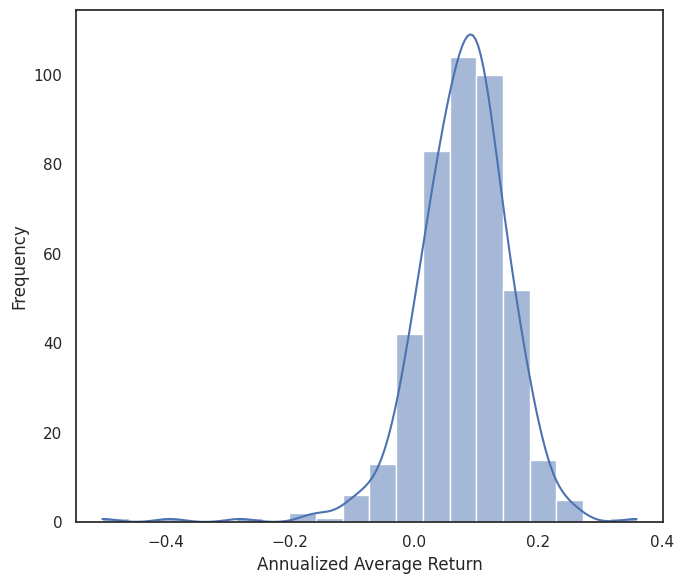

In [312]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.histplot(annualized_avg_returns, bins=20, color='b', kde=True, ax=ax)
ax.set_xlabel('Annualized Average Return')
ax.set_ylabel('Frequency')

plt.tight_layout()
#plt.savefig('/content/histogram_of_annualized_avg_returns.pdf', dpi=600)
plt.show()

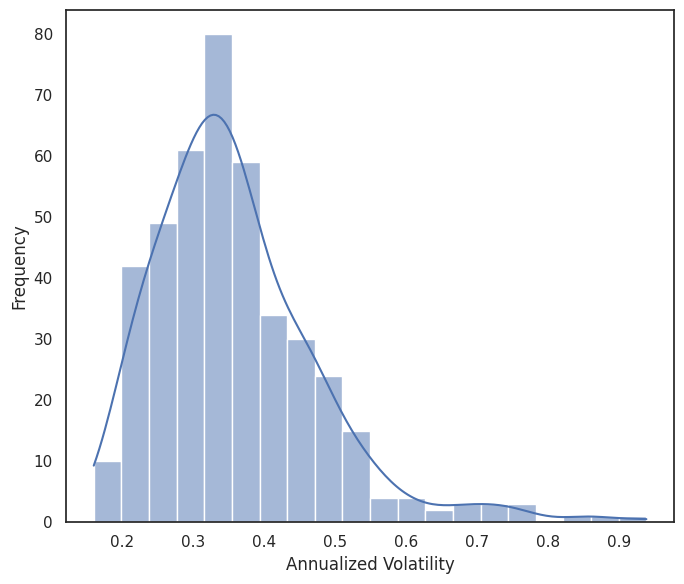

In [313]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.histplot(annualized_volatilities, bins=20, color='b', kde=True, ax=ax)
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Frequency')

plt.tight_layout()
#plt.savefig('/content/histogram_of_annualized_volatilities.pdf', dpi=600)
plt.show()

In [314]:
#Compute the correlation
correlation = annualized_avg_returns.corr(annualized_volatilities)

correlation

-0.260996432143303

There is a weak negative correlation between the annualised avarage returns and volatility for the assets, which means that the higher returns are not systematically associated with higher risk (volatility), and vice versa.

In [315]:
"""
plt.figure(figsize=(10, 6))
plt.scatter(annualized_avg_returns, annualized_volatilities, alpha=0.6)
plt.title('Scatterplot of Annualized Average Returns vs. Annualized Volatilities')
plt.xlabel('Annualized Average Return')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.show()
"""

"\nplt.figure(figsize=(10, 6))\nplt.scatter(annualized_avg_returns, annualized_volatilities, alpha=0.6)\nplt.title('Scatterplot of Annualized Average Returns vs. Annualized Volatilities')\nplt.xlabel('Annualized Average Return')\nplt.ylabel('Annualized Volatility')\nplt.grid(True)\nplt.show()\n"

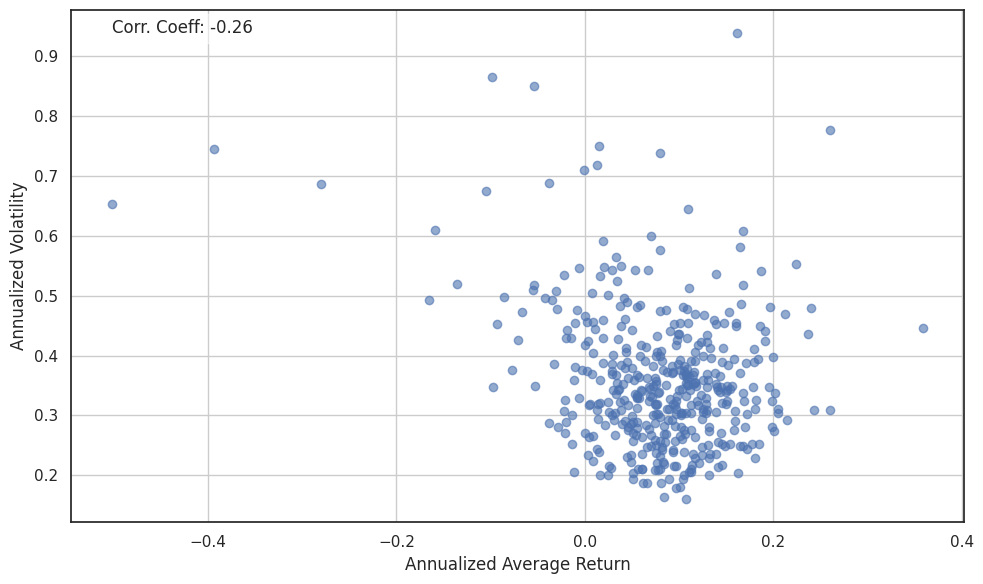

In [316]:
# Calculate the Pearson correlation coefficient
from scipy.stats import pearsonr
corr_coeff, _ = pearsonr(annualized_avg_returns, annualized_volatilities)

# Plotting the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(annualized_avg_returns, annualized_volatilities, alpha=0.6)
#plt.title('Scatterplot of Annualized Average Returns vs. Annualized Volatilities')
plt.xlabel('Annualized Average Return')
plt.ylabel('Annualized Volatility')
plt.grid(True)

# Display the correlation coefficient on the plot
plt.text(x=min(annualized_avg_returns), y=max(annualized_volatilities),
         s=f'Corr. Coeff: {corr_coeff:.2f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
#plt.savefig('/content/scatterplot_AAR_AV.pdf', dpi=600)
plt.show()

In [317]:
fig = px.scatter(x=annualized_avg_returns, y=annualized_volatilities,
                 title='Scatterplot of Annualized Average Returns vs. Annualized Volatilities',
                 labels={'x': 'Annualized Average Return', 'y': 'Annualized Volatility'},
                 width=1000,
                 height=600,
                 opacity=0.6)

fig.show()

## **Task 2**



---



**Equally-Weighted Portfolio:** This portfolio gives the same weight to each asset, regardless of the company's size.

In [318]:
#Since all assets have the same weight in an equally-weighted portfolio, we can simply take the mean of the returns
ew_portfolio_returns = simple_returns.mean(axis=0)
ew_portfolio_returns.describe()

count    179.000000
mean       0.006510
std        0.067844
min       -0.265958
25%       -0.029570
50%        0.007638
75%        0.047567
max        0.257990
dtype: float64

In [319]:
ew_portfolio_returns

2008-02-29    0.036790
2008-03-31    0.023037
2008-04-30    0.018328
2008-05-31    0.001461
2008-06-30   -0.109627
                ...   
2022-08-31   -0.069363
2022-09-30   -0.112162
2022-10-31    0.082515
2022-11-30    0.109995
2022-12-31    0.011872
Length: 179, dtype: float64

In [320]:
ew_portfolio_returns.mean()

0.00651040958388197

Another way to calculate it:

In [321]:
equal_weights = 1 / df_prices_month_eur_filtered.shape[0] #number of rows, our companies

In [322]:
equal_weights = np.array(equal_weights)

In [323]:
portfolio_ret=(simple_returns*equal_weights).sum(axis=0)
portfolio_ret

2008-02-29    0.036790
2008-03-31    0.023037
2008-04-30    0.018328
2008-05-31    0.001461
2008-06-30   -0.109627
                ...   
2022-08-31   -0.069363
2022-09-30   -0.112162
2022-10-31    0.082515
2022-11-30    0.109736
2022-12-31    0.011845
Length: 179, dtype: float64

In [324]:
#Portfolio expected return
mean_portfolio = portfolio_ret.mean()
mean_portfolio

0.006509264034368745

In [325]:
ew_portfolio_volatility = portfolio_ret.std()
ew_portfolio_volatility

0.06784159012338316

**Market-Cap (or Value) Weighted Portfolio:** This portfolio weights each asset according to the company's market capitalization relative to the total market capitalization of all assets in the portfolio.

In [326]:
df_market_value_month_eur.set_index('ISIN', inplace=True)

In [327]:
df_market_value_month_eur = df_market_value_month_eur.drop('NAME', axis=1)

In [328]:
df_market_value_month_eur = df_market_value_month_eur.drop('Country_Code', axis=1)
df_market_value_month_eur

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
ISIN,,,,,,,,,,,,,,,,,,,,,
AT00000VIE62,567.85,559.05,576.48,498.86,517.64,554.94,525.07,532.96,561.74,565.78,...,2453.36,2388.16,2366.48,2875.89,2809.31,2778.87,2719.75,2739.62,2854.20,2900.21
AT0000652011,1803.98,1857.91,1910.40,1827.24,1810.26,1887.98,1894.88,1976.01,2132.84,2049.14,...,15823.98,13448.16,13356.15,10873.35,10824.56,9715.28,9532.79,10602.50,13099.32,13715.54
AT0000743059,2583.84,2113.74,2065.10,2223.10,2305.32,2355.20,1976.43,2004.76,1951.03,1830.13,...,15799.81,16951.82,19071.10,15313.75,13821.87,13255.37,11981.47,15085.69,16902.76,16800.81
AT0000746409,1655.07,1781.21,1618.73,1446.45,1554.72,1556.20,1497.30,1409.89,1403.01,1215.81,...,18088.45,18353.60,16894.99,16612.75,18659.53,16321.45,14584.20,13333.42,15082.96,14289.58
AT0000831706,1386.43,1283.95,1428.44,1487.43,1567.26,1583.88,1544.56,1482.09,1487.63,1305.31,...,3511.64,3280.93,3173.55,2466.15,2635.59,2703.34,2324.62,2634.32,2896.84,2690.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE0015961909,197.04,212.77,232.88,218.50,209.29,195.95,193.50,193.98,191.47,176.40,...,36967.64,34052.38,31539.59,26908.59,30279.29,26713.27,24484.81,25645.89,28753.87,27149.01
SE0016589188,7593.79,6702.68,6739.48,6026.53,6006.13,5542.50,5300.71,4415.66,4473.49,4478.41,...,4617.69,4245.08,4258.84,3692.71,3933.26,3496.16,2878.77,3389.53,3828.45,3714.02
SE0017486889,3539.84,3231.37,3400.32,3273.63,3104.37,2711.52,2936.46,2890.92,2403.54,2959.92,...,44287.14,38732.62,37523.50,31313.66,38867.54,34336.09,31707.46,35865.30,40666.87,39667.59


In [329]:
start_column_2008 = next((col for col in df_market_value_month_eur.columns if pd.to_datetime(col).year == 2008), None)
end_column = df_market_value_month_eur.columns[-1]

if start_column_2008:
    df_market_value_month_eur_filtered = df_market_value_month_eur.loc[:, start_column_2008:end_column]
else:
    df_market_value_month_eur_filtered = df_market_value_month_eur

df_market_value_month_eur_filtered.head()

,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
ISIN,,,,,,,,,,,,,,,,,,,,,
AT00000VIE62,2329.71,2405.60,2539.90,2654.84,2412.28,2004.98,1788.33,1712.25,1311.39,851.86,...,2453.36,2388.16,2366.48,2875.89,2809.31,2778.87,2719.75,2739.62,2854.20,2900.21
AT0000652011,16951.92,18485.57,20573.03,23489.06,24118.28,19703.31,20356.52,19083.13,15304.40,8318.12,...,15823.98,13448.16,13356.15,10873.35,10824.56,9715.28,9532.79,10602.50,13099.32,13715.54
AT0000743059,21320.11,21814.48,19898.56,22629.68,24671.05,23566.34,20782.60,19328.25,12358.80,9506.49,...,15799.81,16951.82,19071.10,15313.75,13821.87,13255.37,11981.47,15085.69,16902.76,16800.81
AT0000746409,9860.39,11244.90,10789.72,11694.93,12743.09,13542.92,12045.23,11463.98,9152.77,7085.38,...,18088.45,18353.60,16894.99,16612.75,18659.53,16321.45,14584.20,13333.42,15082.96,14289.58
AT0000831706,3809.48,4090.74,4481.37,4838.47,4447.15,3527.37,2265.95,2224.72,2237.94,1373.19,...,3511.64,3280.93,3173.55,2466.15,2635.59,2703.34,2324.62,2634.32,2896.84,2690.25


In [330]:
#total market cap for each date
total_market_cap = df_market_value_month_eur_filtered.sum(axis=0)

#Weights for each asset for each date
weights = df_market_value_month_eur_filtered.div(total_market_cap, axis=1)

#portfolio returns for each date
vw_portfolio_returns = (simple_returns.shift(-1) * weights).sum(axis=0)

In [331]:
total_market_cap

2008-01-31    8283433.25
2008-02-29    8414937.45
2008-03-31    8455089.09
2008-04-30    8730889.49
2008-05-31    8726661.17
                 ...    
2022-08-31    8401775.75
2022-09-30    7679028.45
2022-10-31    8243791.32
2022-11-30    9167555.39
2022-12-31    9122658.42
Length: 180, dtype: float64

In [332]:
vw_portfolio_returns

2008-01-31    0.000000
2008-02-29    0.036120
2008-03-31    0.025300
2008-04-30    0.011529
2008-05-31    0.002461
                ...   
2022-08-31   -0.072770
2022-09-30   -0.109179
2022-10-31    0.087966
2022-11-30    0.103843
2022-12-31    0.010060
Length: 180, dtype: float64

We will now continue with the calculation of the annualized statistics for both portfolios

In [333]:
ew_portfolio_returns = ew_portfolio_returns.dropna()
vw_portfolio_returns = vw_portfolio_returns.dropna()

In [334]:
ew_portfolio_returns.describe()

count    179.000000
mean       0.006510
std        0.067844
min       -0.265958
25%       -0.029570
50%        0.007638
75%        0.047567
max        0.257990
dtype: float64

In [335]:
vw_portfolio_returns.describe()

count    180.000000
mean       0.006531
std        0.066566
min       -0.246441
25%       -0.028725
50%        0.007007
75%        0.046976
max        0.252397
dtype: float64

In [336]:
vw_portfolio_returns

2008-01-31    0.000000
2008-02-29    0.036120
2008-03-31    0.025300
2008-04-30    0.011529
2008-05-31    0.002461
                ...   
2022-08-31   -0.072770
2022-09-30   -0.109179
2022-10-31    0.087966
2022-11-30    0.103843
2022-12-31    0.010060
Length: 180, dtype: float64

In [337]:
vw_portfolio_expected = vw_portfolio_returns.mean()
vw_portfolio_expected

0.006530952381570154

In [338]:
vw_portfolio_volatility = vw_portfolio_returns.std()
vw_portfolio_volatility

0.06656626785094812

In [339]:
def calculate_annualized_statistics(returns):
    annualized_return = returns.mean(axis=0) * 12
    annualized_volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    min_return = returns.min()
    max_return = returns.max()
    return annualized_return, annualized_volatility, min_return, max_return, sharpe_ratio

In [340]:
ew_stats = calculate_annualized_statistics(ew_portfolio_returns)

In [341]:
vw_stats = calculate_annualized_statistics(vw_portfolio_returns)

In [342]:
ew_vw_stats_combined = pd.DataFrame({
    'Statistic': ['Annualized Return', 'Annualized Volatility', 'Min Return', 'Max Return', 'Sharpe Ratio'],
    'EW Portfolio': ew_stats,
    'VW Portfolio': vw_stats
})

ew_vw_stats_combined

,Statistic,EW Portfolio,VW Portfolio
0,Annualized Return,0.078125,0.078371
1,Annualized Volatility,0.235019,0.230592
2,Min Return,-0.265958,-0.246441
3,Max Return,0.257990,0.252397
4,Sharpe Ratio,0.326599,0.333937


In [343]:
print(f"For the equally weighted portfolio the minimum return is {ew_vw_stats_combined.iloc[2,1] * 100:.2f}% \
and the maximum is {ew_vw_stats_combined.iloc[3,1] * 100:.2f}%, while for market-cap weighted portfolio \
it is {ew_vw_stats_combined.iloc[2,2] * 100:.2f}% and {ew_vw_stats_combined.iloc[3,2] * 100:.2f}%")

For the equally weighted portfolio the minimum return is -26.60% and the maximum is 25.80%, while for market-cap weighted portfolio it is -24.64% and 25.24%


In [344]:
print(f"With the risk free rate {risk_free_rate * 100:.2f}%, \
Sharpe ratio for the equally weighted portfolio is {ew_vw_stats_combined.iloc[4, 1] * 100:.2f}%, \
while for the market-cap weighted portfolio it is {ew_vw_stats_combined.iloc[4, 2] * 100:.2f}%")

With the risk free rate 0.14%, Sharpe ratio for the equally weighted portfolio is 32.66%, while for the market-cap weighted portfolio it is 33.39%


In [345]:
latex_code = ew_vw_stats_combined.to_latex(index=False)
"""
# Save the LaTeX code to a file
file_path = '/content/ew_vw_stats_combined.tex'
with open(file_path, 'w') as f:
    f.write(latex_code)

file_path
"""

<ipython-input-345-52c1b408a52b>:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



"\n# Save the LaTeX code to a file\nfile_path = '/content/ew_vw_stats_combined.tex'\nwith open(file_path, 'w') as f:\n    f.write(latex_code)\n\nfile_path\n"



---



We further calculate the cumulative returns for both portfolios

$\text{Cumulative Returns} = \left(\prod_{t=1}^{n} (1 + r_t) \right) - 1$

where, $r_t$ is the return at time $t$,
  and $n$ is the number of periods.

In [346]:
# Cumulative returns
ew_cumulative_returns = (1 + ew_portfolio_returns).cumprod() - 1
vw_cumulative_returns = (1 + vw_portfolio_returns).cumprod() - 1

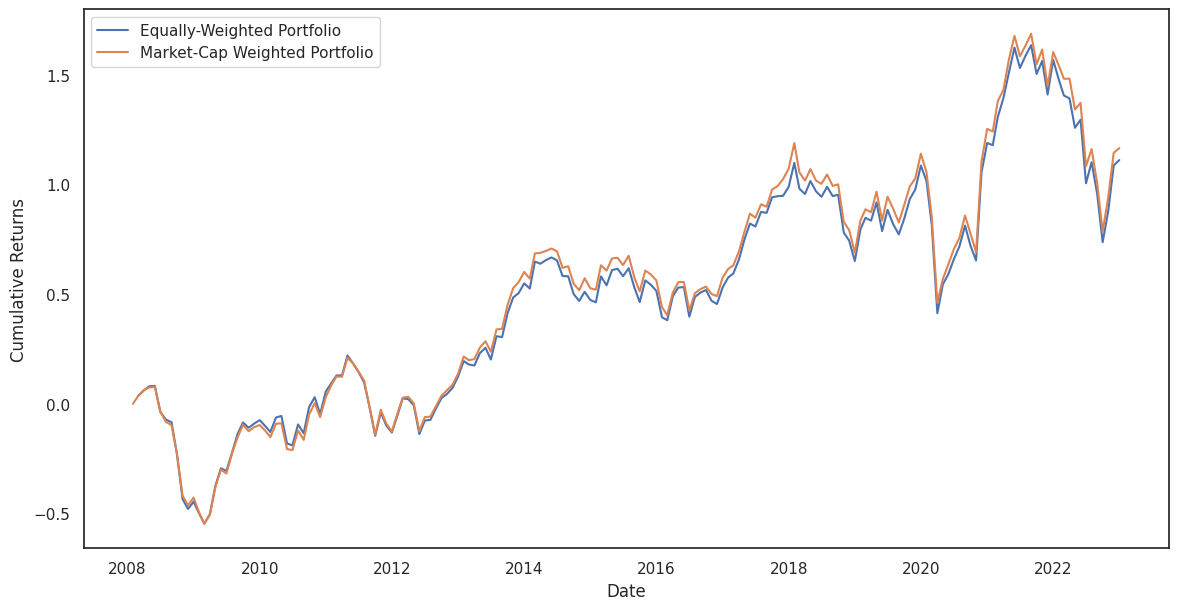

In [347]:
# Plotting the cumulative returns for both portfolios
plt.figure(figsize=(14, 7))
plt.plot(ew_cumulative_returns.index, ew_cumulative_returns, label='Equally-Weighted Portfolio')
plt.plot(vw_cumulative_returns.index, vw_cumulative_returns, label='Market-Cap Weighted Portfolio')
plt.legend()
#plt.title('Cumulative Returns of Equally-Weighted vs Market-Cap Weighted Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
#plt.savefig('/content/cumulative_ew_vw.pdf', dpi=600)
plt.show()

In [348]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=ew_cumulative_returns.index, y=ew_cumulative_returns, name='Equally-Weighted Portfolio'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=vw_cumulative_returns.index, y=vw_cumulative_returns, name='Market-Cap Weighted Portfolio'),
    secondary_y=False,
)

fig.update_layout(
    title_text="Cumulative Returns of Portfolios",
    width=1450,
    height=500,
)

fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Cumulative Returns", secondary_y=False)
fig.show()


## **Task 3**



### Data cleaning for task 3

Take all firms in your dataset for which you have an E/S/G score or carbon emissions from 2007 on

In [349]:
import scipy.optimize as sco

In [350]:
columns_of_interest = ['ISIN', 'NAME','Country_Code'] + [f'x{year}' for year in range(2007, 2023)]
df_S_2007 = s_score[columns_of_interest]
df_S_2007

,ISIN,NAME,Country_Code,x2007,x2008,x2009,x2010,x2011,x2012,x2013,x2014,x2015,x2016,x2017,x2018,x2019,x2020,x2021,x2022
0,AN8068571086,SCHLUMBERGER,AN,45.72,34.93,31.99,38.55,31.47,41.31,35.41,46.74,46.22,64.41,65.88,73.60,72.93,79.13,87.06,86.11
1,AT000000STR1,STRABAG SE,AT,42.56,41.50,33.35,32.27,33.44,39.81,42.32,36.03,37.51,37.97,77.52,77.44,81.25,81.14,80.54,75.93
2,AT00000VIE62,FLUGHAFEN WIEN,AT,18.94,20.60,19.41,22.71,35.97,37.49,36.83,36.16,41.09,40.27,54.13,47.44,44.88,42.69,44.49,NaN
3,AT0000606306,RAIFFEISEN BANK INTL.,AT,30.04,34.03,25.67,65.58,61.71,49.06,51.30,51.14,53.54,71.45,75.91,90.95,91.57,87.49,86.93,85.91
4,AT0000652011,ERSTE GROUP BANK,AT,35.48,36.47,36.40,34.92,34.34,35.21,36.36,47.22,48.56,47.44,83.09,80.42,82.81,79.64,74.79,74.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,US9839191015,XILINX DEAD - DELIST.15/02/22,US,77.78,87.56,81.21,82.15,76.85,66.99,63.42,57.48,54.25,61.52,59.13,NaN,56.08,61.56,NaN,NaN
1527,US98421M1062,XEROX HOLDINGS,US,86.29,81.97,77.56,76.15,70.44,61.21,64.93,62.59,77.47,62.10,70.35,72.53,65.83,66.08,68.52,63.49
1528,US9884981013,YUM! BRANDS,US,73.99,80.78,87.54,88.20,84.49,85.45,84.08,82.35,82.18,71.68,85.42,85.61,85.85,86.40,87.37,NaN
1529,US98956P1021,ZIMMER BIOMET HDG.,US,49.76,48.29,50.32,50.68,50.28,44.13,36.26,29.24,41.21,60.98,59.46,59.10,75.97,79.77,80.39,81.45


In [351]:
df_S_europe = df_S_2007[df_S_2007['Country_Code'].isin(european_country_codes)]
df_S_europe

,ISIN,NAME,Country_Code,x2007,x2008,x2009,x2010,x2011,x2012,x2013,x2014,x2015,x2016,x2017,x2018,x2019,x2020,x2021,x2022
1,AT000000STR1,STRABAG SE,AT,42.56,41.50,33.35,32.27,33.44,39.81,42.32,36.03,37.51,37.97,77.52,77.44,81.25,81.14,80.54,75.93
2,AT00000VIE62,FLUGHAFEN WIEN,AT,18.94,20.60,19.41,22.71,35.97,37.49,36.83,36.16,41.09,40.27,54.13,47.44,44.88,42.69,44.49,NaN
3,AT0000606306,RAIFFEISEN BANK INTL.,AT,30.04,34.03,25.67,65.58,61.71,49.06,51.30,51.14,53.54,71.45,75.91,90.95,91.57,87.49,86.93,85.91
4,AT0000652011,ERSTE GROUP BANK,AT,35.48,36.47,36.40,34.92,34.34,35.21,36.36,47.22,48.56,47.44,83.09,80.42,82.81,79.64,74.79,74.31
5,AT0000720008,TELEKOM AUSTRIA,AT,56.13,59.13,65.76,63.31,65.02,74.40,73.83,68.47,66.16,62.40,63.65,60.42,57.78,75.31,71.21,71.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,SE0016589188,ELECTROLUX B,SE,65.04,54.58,67.66,62.59,73.58,68.58,73.73,79.64,79.42,83.44,82.32,82.46,84.98,85.61,85.69,84.43
1078,SE0017486889,ATLAS COPCO A,SE,90.01,93.60,88.63,88.63,89.96,86.42,84.66,88.19,91.63,91.70,90.26,91.99,88.87,91.50,91.41,90.23
1079,SE0018012494,MODERN TIMES GROUP MTG B,SE,9.24,36.01,55.82,62.29,87.26,93.23,92.96,87.89,95.05,89.31,89.95,92.39,88.12,87.52,86.41,82.49
1080,SE0018012635,WIHLBORGS FASTIGHETER,SE,39.77,49.14,63.47,67.55,72.99,70.37,66.21,65.42,67.10,55.91,55.10,61.83,54.75,55.64,49.06,57.45


In [352]:
missing_values_count = df_S_europe.isnull().sum()

# Print the count of missing values for each column
print(missing_values_count)

ISIN             0
NAME             0
Country_Code     0
x2007            0
x2008            1
x2009            0
x2010            0
x2011            0
x2012            0
x2013            0
x2014            0
x2015            0
x2016            0
x2017            0
x2018            0
x2019            0
x2020            2
x2021            6
x2022           60
dtype: int64


In [353]:
unique_companies = df_S_europe[['NAME', 'ISIN']].drop_duplicates()
unique_companies

,NAME,ISIN
1,STRABAG SE,AT000000STR1
2,FLUGHAFEN WIEN,AT00000VIE62
3,RAIFFEISEN BANK INTL.,AT0000606306
4,ERSTE GROUP BANK,AT0000652011
5,TELEKOM AUSTRIA,AT0000720008
...,...,...
1077,ELECTROLUX B,SE0016589188
1078,ATLAS COPCO A,SE0017486889
1079,MODERN TIMES GROUP MTG B,SE0018012494
1080,WIHLBORGS FASTIGHETER,SE0018012635


match companies in social score with companies in prices/returns

In [354]:
if 'ISIN' in df_prices_month.columns:
    df_prices_month.set_index('ISIN', inplace=True)

df_prices_A = df_prices_month[df_prices_month.index.isin(unique_companies['ISIN'])]

df_prices_A.columns = pd.to_datetime(df_prices_A.columns, errors='coerce')

start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2021-12-31')

filtered_cols = df_prices_A.columns[(df_prices_A.columns >= start_date) & (df_prices_A.columns <= end_date)]
df_prices_A = df_prices_A[filtered_cols]

df_prices_A = df_prices_A.T
df_prices_A

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2008-01-31,675.06,581.50,3625.06,3526.82,6910.60,905.26,1542.98,492.13,297.05,8465.75,...,556.31,61.98,110.91,1066.50,140.48,601.78,1018.06,1117.07,106.75,5.80
2008-02-29,697.06,634.11,3709.12,4022.03,7420.82,998.30,1613.71,515.99,345.48,8603.67,...,583.83,72.51,109.53,1155.72,151.45,718.34,1066.58,1248.71,117.69,7.46
2008-03-31,735.97,705.71,3383.35,3859.22,8129.44,912.96,1773.02,510.09,344.53,8718.29,...,584.69,70.20,107.52,1218.89,140.73,707.92,1081.99,1359.51,125.01,6.92
2008-04-30,769.28,805.74,3847.73,4264.39,8777.25,908.79,1949.98,526.92,349.88,10007.80,...,572.49,65.41,121.24,1327.55,145.22,630.92,1052.89,1317.22,131.45,7.06
2008-05-31,721.04,840.70,4290.16,4646.59,8382.51,922.18,2117.04,536.96,372.86,9897.00,...,608.63,60.94,124.99,1389.79,140.81,734.66,988.11,1447.63,129.20,7.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,1219.23,600.34,4909.00,8537.33,8149.14,570.39,1786.10,1563.18,131.69,13569.03,...,2887.10,396.71,784.57,8263.76,968.46,5908.62,3148.96,11060.64,123.60,35.97
2021-09-30,1275.83,662.51,5358.74,7925.44,7013.84,567.99,1463.13,1417.84,123.53,12925.61,...,2510.16,336.24,708.38,7499.28,920.05,5305.60,2933.81,9811.84,105.58,33.32
2021-10-31,1212.26,644.84,5373.35,8130.25,7359.14,575.12,1497.44,1460.35,128.59,12324.97,...,2521.85,375.34,785.77,7971.53,923.99,5485.98,3145.18,10430.64,99.36,36.42
2021-11-30,1121.19,668.96,4684.82,8118.56,7597.37,542.77,1325.21,1432.10,123.74,11535.45,...,2537.77,369.54,712.74,8316.52,762.02,4966.29,3092.73,9928.99,86.19,35.45


### Efficient frontier

Compute the average (or expected) return and the covariance matrix matrix for the 2008–2021 period

In [355]:
monthly_returns= df_prices_A.pct_change()
monthly_returns = monthly_returns.dropna()
monthly_returns

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2008-02-29,0.032590,0.090473,0.023189,0.140413,0.073832,0.102777,0.045840,0.048483,0.163037,0.016292,...,0.049469,0.169894,-0.012443,0.083657,0.078089,0.193692,0.047659,0.117844,0.102482,0.286207
2008-03-31,0.055820,0.112914,-0.087829,-0.040480,0.095491,-0.085485,0.098723,-0.011434,-0.002750,0.013322,...,0.001473,-0.031858,-0.018351,0.054659,-0.070782,-0.014506,0.014448,0.088732,0.062197,-0.072386
2008-04-30,0.045260,0.141744,0.137254,0.104988,0.079687,-0.004568,0.099807,0.032994,0.015528,0.147909,...,-0.020866,-0.068234,0.127604,0.089147,0.031905,-0.108769,-0.026895,-0.031107,0.051516,0.020231
2008-05-31,-0.062708,0.043389,0.114985,0.089626,-0.044973,0.014734,0.085673,0.019054,0.065680,-0.011071,...,0.063128,-0.068338,0.030930,0.046883,-0.030368,0.164427,-0.061526,0.099004,-0.017117,0.096317
2008-06-30,-0.168839,-0.183062,-0.044779,0.062766,-0.206827,-0.130105,-0.013028,-0.090863,-0.122754,-0.085832,...,-0.135978,-0.233837,-0.135371,-0.148030,-0.034941,-0.074184,-0.111364,-0.166154,-0.154412,-0.276486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,-0.000959,0.030485,0.026322,0.186019,-0.039756,0.051139,0.028155,-0.008952,0.073706,-0.018228,...,-0.035453,0.044056,-0.103205,-0.036580,0.029597,0.044925,-0.035759,0.013797,0.002514,-0.106557
2021-09-30,0.046423,0.103558,0.091615,-0.071672,-0.139315,-0.004208,-0.180824,-0.092977,-0.061964,-0.047418,...,-0.130560,-0.152429,-0.097111,-0.092510,-0.049987,-0.102058,-0.068324,-0.112905,-0.145793,-0.073673
2021-10-31,-0.049826,-0.026671,0.002726,0.025842,0.049231,0.012553,0.023450,0.029982,0.040962,-0.046469,...,0.004657,0.116286,0.109249,0.062973,0.004282,0.033998,0.072046,0.063067,-0.058913,0.093037
2021-11-30,-0.075124,0.037405,-0.128138,-0.001438,0.032372,-0.056249,-0.115016,-0.019345,-0.037717,-0.064059,...,0.006313,-0.015453,-0.092941,0.043278,-0.175294,-0.094731,-0.016676,-0.048094,-0.132548,-0.026634


In [356]:
expected_returns = monthly_returns.mean()
expected_returns

ISIN
AT00000VIE62    0.007420
AT0000652011    0.011098
AT0000743059    0.007548
AT0000746409    0.010299
AT0000831706    0.008694
                  ...   
SE0015961909    0.019910
SE0016589188    0.012274
SE0017486889    0.017602
SE0018012494    0.006269
SE0020050417    0.020676
Length: 426, dtype: float64

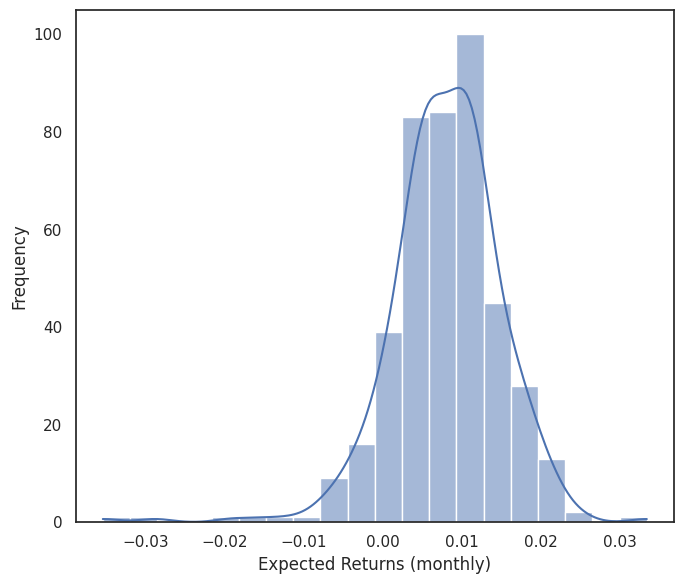

In [357]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.histplot(expected_returns, bins=20, color='b', kde=True, ax=ax)
ax.set_xlabel('Expected Returns (monthly)')
ax.set_ylabel('Frequency')

plt.tight_layout()
#plt.savefig('/content/histogram_of_monthly_exp_returns.pdf', dpi=600)
plt.show()

In [358]:
exp_stat = expected_returns.describe()

In [359]:
# Convert the descriptive statistics to a DataFrame with 2 rows
exp_stat_df = pd.DataFrame(exp_stat).transpose()
"""
# Export the DataFrame to a LaTeX file
tex_file_path = '/content/MER_descriptive_stats.tex'
exp_stat_df.to_latex(tex_file_path, index=False)

tex_file_path
"""

"\n# Export the DataFrame to a LaTeX file\ntex_file_path = '/content/MER_descriptive_stats.tex'\nexp_stat_df.to_latex(tex_file_path, index=False)\n\ntex_file_path\n"

In [360]:
covariance_matrix = monthly_returns.cov()
covariance_matrix

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
ISIN,,,,,,,,,,,,,,,,,,,,,
AT00000VIE62,0.008725,0.007817,0.005519,0.004759,0.006139,0.005697,0.005836,0.003414,0.007684,0.004670,...,0.002933,0.004171,0.004414,0.003519,0.001961,0.004621,0.004310,0.003641,0.005728,0.004872
AT0000652011,0.007817,0.019207,0.008767,0.007771,0.010491,0.009714,0.008307,0.004905,0.011429,0.008987,...,0.004757,0.006328,0.006812,0.006423,0.003427,0.008506,0.007275,0.006280,0.008669,0.010953
AT0000743059,0.005519,0.008767,0.011223,0.005741,0.005629,0.005631,0.006712,0.003764,0.009102,0.006408,...,0.003063,0.004696,0.005315,0.003842,0.002441,0.005271,0.004580,0.004267,0.005628,0.008107
AT0000746409,0.004759,0.007771,0.005741,0.009737,0.005468,0.005263,0.005919,0.002950,0.007055,0.004538,...,0.003335,0.004471,0.004637,0.003686,0.002193,0.004777,0.003535,0.003394,0.004811,0.005560
AT0000831706,0.006139,0.010491,0.005629,0.005468,0.015792,0.007453,0.009088,0.004106,0.010274,0.007658,...,0.006133,0.007203,0.007806,0.005896,0.002211,0.008034,0.007586,0.006650,0.009172,0.007450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE0015961909,0.004621,0.008506,0.005271,0.004777,0.008034,0.006277,0.008507,0.003464,0.009303,0.006326,...,0.004888,0.006852,0.007042,0.005828,0.003143,0.013313,0.008185,0.007544,0.008666,0.010518
SE0016589188,0.004310,0.007275,0.004580,0.003535,0.007586,0.005459,0.006637,0.002660,0.007314,0.005519,...,0.004409,0.005315,0.005500,0.004879,0.002585,0.008185,0.010689,0.005852,0.006871,0.008430
SE0017486889,0.003641,0.006280,0.004267,0.003394,0.006650,0.005099,0.006807,0.002828,0.007290,0.005249,...,0.004231,0.005567,0.005296,0.004657,0.002113,0.007544,0.005852,0.007404,0.006836,0.007929


In [361]:
cov_df = pd.DataFrame(covariance_matrix)

# Sélection des 5 premières lignes et colonnes
truncated_cov_df = cov_df.iloc[:5, :5]

# Ajouter une ligne et une colonne de "..."
truncated_cov_df.loc['...'] = ['...' for _ in range(5)]  # Add "..." in last row
truncated_cov_df['...'] = ['...' for _ in range(6)]  # Add "..." in last column

# Afficher le résultat
print(truncated_cov_df)
"""
latex_output = truncated_cov_df.to_latex()
with open('truncated_cov_matrix.tex', 'w') as f:
    f.write(latex_output)
"""

ISIN         AT00000VIE62 AT0000652011 AT0000743059 AT0000746409 AT0000831706  \
ISIN                                                                            
AT00000VIE62     0.008725     0.007817     0.005519     0.004759     0.006139   
AT0000652011     0.007817     0.019207     0.008767     0.007771     0.010491   
AT0000743059     0.005519     0.008767     0.011223     0.005741     0.005629   
AT0000746409     0.004759     0.007771     0.005741     0.009737     0.005468   
AT0000831706     0.006139     0.010491     0.005629     0.005468     0.015792   
...                   ...          ...          ...          ...          ...   

ISIN          ...  
ISIN               
AT00000VIE62  ...  
AT0000652011  ...  
AT0000743059  ...  
AT0000746409  ...  
AT0000831706  ...  
...           ...  


"\nlatex_output = truncated_cov_df.to_latex()\nwith open('truncated_cov_matrix.tex', 'w') as f:\n    f.write(latex_output)\n"

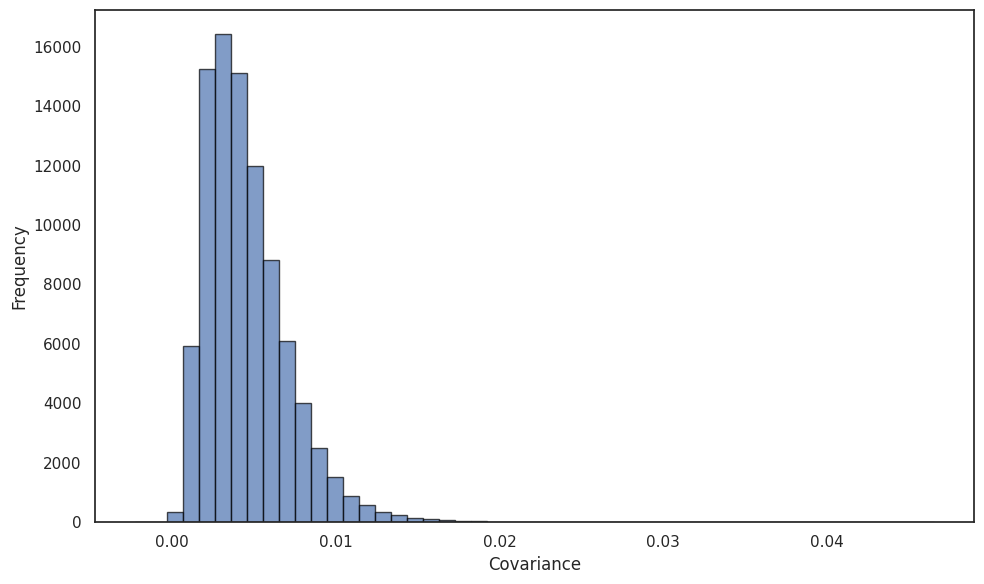

In [362]:
cov_values = covariance_matrix.values[np.triu_indices_from(covariance_matrix, k=1)]
# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(cov_values, bins=50, alpha=0.7, color='b', edgecolor='black')

# Ajout de titres et étiquettes
#plt.title('Histogram of Covariance Values')
plt.xlabel('Covariance')
plt.ylabel('Frequency')

plt.tight_layout()
#plt.savefig('/content/histogram_of_cov_mat.pdf', dpi=600)
plt.show()

In [363]:
descriptive_stats = pd.Series(cov_values).describe()
descriptive_stats

count    90525.000000
mean         0.004537
std          0.002541
min         -0.002261
25%          0.002687
50%          0.004046
75%          0.005827
max          0.046525
dtype: float64

In [364]:
# Convert the descriptive statistics to a DataFrame with 2 rows
cov_stat_df = pd.DataFrame(descriptive_stats).transpose()
"""
# Export the DataFrame to a LaTeX file
tex_file_path = '/content/COVM_descriptive_stats.tex'
cov_stat_df.to_latex(tex_file_path, index=False)

tex_file_path
"""

"\n# Export the DataFrame to a LaTeX file\ntex_file_path = '/content/COVM_descriptive_stats.tex'\ncov_stat_df.to_latex(tex_file_path, index=False)\n\ntex_file_path\n"

### Minimum Variance Portfolio and the Maximum Return Portfolio

In [365]:
mu = np.array(expected_returns)
Sigma = np.array(covariance_matrix)

#number of assets
n_assets = mu.shape[0]

#objective functions
def portfolio_variance(weights, covariance_matrix):
    return weights.T @ covariance_matrix @ weights

def portfolio_return(weights, expected_returns):
    return weights.T @ expected_returns

#constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # The sum of weights is 1
               {'type': 'ineq', 'fun': lambda x: x})            # Weights are non-negative

bounds = tuple((0, 1) for asset in range(n_assets))

#equal weights for all the assets
initial_weights = np.ones(n_assets) / n_assets

#optimization for minimum variance portfolio
min_var_portfolio = minimize(portfolio_variance, initial_weights, args=(Sigma,), method='SLSQP', bounds=bounds, constraints=constraints)

#optimization for maximum return portfolio
max_ret_portfolio = minimize(lambda w: -portfolio_return(w, mu), initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

min_var_portfolio, max_ret_portfolio

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: 0.0009417339702329679
        x: [ 3.684e-19  0.000e+00 ...  4.180e-18  1.191e-18]
      nit: 28
      jac: [ 3.447e-03  4.865e-03 ...  4.311e-03  3.544e-03]
     nfev: 11957
     njev: 28,
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: -0.0333319177741905
        x: [ 1.988e-16  2.882e-16 ...  0.000e+00  1.594e-16]
      nit: 19
      jac: [-7.420e-03 -1.110e-02 ... -6.269e-03 -2.068e-02]
     nfev: 8113
     njev: 19)

In [366]:
x = min_var_portfolio.x
x_first_5 = x[:5]
W_MIN = pd.DataFrame([x_first_5], columns=["Firm 1", "Firm 2", "Firm 3", "Firm 4", "Firm 5"])
W_MIN.index = ["weight"]
"""
tex_file_path = '/content/weight_MIN.tex'
W_MIN.to_latex(tex_file_path, index=True)

tex_file_path
"""

"\ntex_file_path = '/content/weight_MIN.tex'\nW_MIN.to_latex(tex_file_path, index=True)\n\ntex_file_path\n"

In [367]:
x = max_ret_portfolio.x
x_first_5 = x[:5]
W_MAX = pd.DataFrame([x_first_5], columns=["Firm 1", "Firm 2", "Firm 3", "Firm 4", "Firm 5"])
W_MAX.index = ["weight"]
"""
tex_file_path = '/content/weight_MAX.tex'
W_MAX.to_latex(tex_file_path, index=False)

tex_file_path
"""

"\ntex_file_path = '/content/weight_MAX.tex'\nW_MAX.to_latex(tex_file_path, index=False)\n\ntex_file_path\n"

The number of the portfolios on the efficient frontier is 6, given the increment change of 0.5%

In [368]:
min_return = portfolio_return(min_var_portfolio.x, mu)
max_return = portfolio_return(max_ret_portfolio.x, mu)

# Calculate the number of target returns for a 1% increment
increment = 0.005  # 0.5% increment
number_of_points = int(1 + (max_return - min_return) / increment)

In [369]:
# How many portfolios do we want to see on our efficient frontier for the further analysis
number_of_points #6

6

In [370]:
# Now we use a loop to compute the efficient frontier for a range of target returns
target_returns = np.linspace(min_return, max_return, num=number_of_points)

efficient_portfolios = []

for target_return in target_returns:
    constraints_with_return = constraints + (
        {'type': 'eq', 'fun': lambda x, target=target_return: portfolio_return(x, mu) - target},
    )
    efficient_portfolio = minimize(portfolio_variance, initial_weights, args=(Sigma,), method='SLSQP', bounds=bounds, constraints=constraints_with_return)
    efficient_portfolios.append(efficient_portfolio)

#portfolio performance metrics
def portfolio_performance(weights, expected_returns, covariance_matrix):
    return {
        "return": portfolio_return(weights, expected_returns),
        "volatility": np.sqrt(portfolio_variance(weights, covariance_matrix))
    }

#performance of the minimum variance and maximum return portfolios
min_var_perf = portfolio_performance(min_var_portfolio.x, mu, Sigma)
max_ret_perf = portfolio_performance(max_ret_portfolio.x, mu, Sigma)

#Lists to hold the return and volatility values for the efficient frontier
frontier_returns = []
frontier_volatilities = []

#performance for each portfolio on the efficient frontier
for portfolio in efficient_portfolios:
    performance = portfolio_performance(portfolio.x, mu, Sigma)
    frontier_returns.append(performance["return"])
    frontier_volatilities.append(performance["volatility"])

In [371]:
print(f'For the Minimum Variance Portfolio the expected return is {min_var_perf["return"]:.4f} and the volatility is {min_var_perf["volatility"]:.4f}, while for Maximum Return Portfolio these are {max_ret_perf["return"]:.4f} and {max_ret_perf["volatility"]:.4f} respectively')


For the Minimum Variance Portfolio the expected return is 0.0073 and the volatility is 0.0307, while for Maximum Return Portfolio these are 0.0333 and 0.1266 respectively


In [372]:
"""
plt.figure(figsize=(10, 7))
plt.scatter(frontier_volatilities, frontier_returns, c='orange', label='Efficient Frontier')
plt.plot(min_var_perf["volatility"], min_var_perf["return"], 'g*', markersize=15, label='Minimum Variance Portfolio')
plt.plot(max_ret_perf["volatility"], max_ret_perf["return"], 'r*', markersize=15, label='Maximum Return Portfolio')

plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend(labelspacing=0.8)
plt.show()
"""

'\nplt.figure(figsize=(10, 7))\nplt.scatter(frontier_volatilities, frontier_returns, c=\'orange\', label=\'Efficient Frontier\')\nplt.plot(min_var_perf["volatility"], min_var_perf["return"], \'g*\', markersize=15, label=\'Minimum Variance Portfolio\')\nplt.plot(max_ret_perf["volatility"], max_ret_perf["return"], \'r*\', markersize=15, label=\'Maximum Return Portfolio\')\n\nplt.title(\'Efficient Frontier\')\nplt.xlabel(\'Volatility\')\nplt.ylabel(\'Expected Return\')\nplt.legend(labelspacing=0.8)\nplt.show()\n'

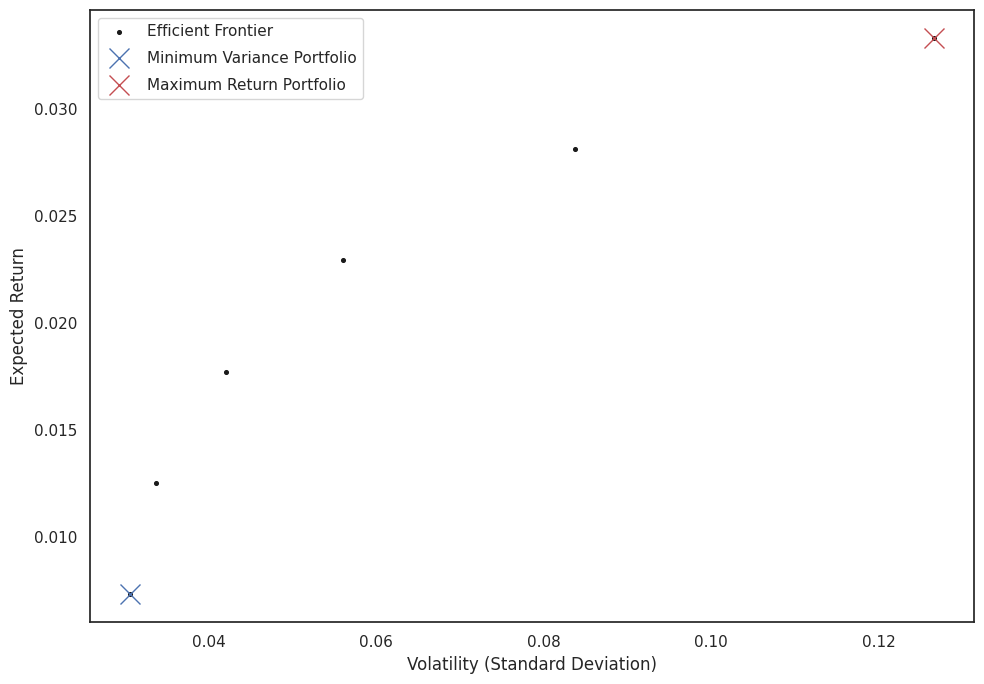

In [373]:
plt.figure(figsize=(10, 7))
plt.scatter(frontier_volatilities, frontier_returns, c='k', s=7, label='Efficient Frontier')
plt.plot(min_var_perf["volatility"], min_var_perf["return"], 'bx', markersize=15, label='Minimum Variance Portfolio')
plt.plot(max_ret_perf["volatility"], max_ret_perf["return"], 'rx', markersize=15, label='Maximum Return Portfolio')

#plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend(labelspacing=0.8)
plt.tight_layout()
#plt.savefig('/content/eff_P_frontier.pdf', dpi=600)
plt.show()

 Just the values of the portfolios on the efficient frontier

In [374]:
portfolios_efficient_frontier_df = pd.DataFrame({
    'Portfolio Number': range(1, len(frontier_returns) + 1),
    'Expected Return': frontier_returns,
    'Volatility': frontier_volatilities
})
portfolios_efficient_frontier_df

,Portfolio Number,Expected Return,Volatility
0,1,0.007314,0.030689
1,2,0.012518,0.033793
2,3,0.017721,0.042125
3,4,0.022925,0.056108
4,5,0.028128,0.083763
5,6,0.033332,0.126595


In [375]:
"""
tex_file_path = '/content/Fron_P_exante_Mon.tex'
portfolios_efficient_frontier_df.to_latex(tex_file_path, index=False)

tex_file_path
"""

"\ntex_file_path = '/content/Fron_P_exante_Mon.tex'\nportfolios_efficient_frontier_df.to_latex(tex_file_path, index=False)\n\ntex_file_path\n"

### Plotting Efficient frontier

#### Ex-ante metrics

The **ex-ante** Sharpe ratio is a predictive measure based on expected returns, volatility, and the risk-free rate. It differs from the ex-post Sharpe ratio, which is calculated based on historical returns, in our case, the `monthly_returns ` that we computed at the beginning of the Task 3.

To compute the ex-ante Sharpe ratio for each portfolio, we would use the expected returns `mu` and the covariance `matrix Sigma`, along with a risk-free rate.

In [376]:
#Ex-ante metrics for the portfolios on the efficient frontier

def ex_ante_performance(weights, expected_returns, covariance_matrix, risk_free_rate, periods_per_year):
    port_return = np.dot(weights, expected_returns) * periods_per_year
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) * np.sqrt(periods_per_year)
    sharpe_ratio = (port_return - risk_free_rate_annual) / port_volatility if port_volatility != 0 else 0
    return port_return, port_volatility, sharpe_ratio


periods_per_year = 12
# Calculating ex-ante performance metrics for each portfolio
ex_ante_metrics = []
for portfolio in efficient_portfolios:
    port_return, port_volatility, sharpe = ex_ante_performance(
        portfolio.x, mu, Sigma, risk_free_rate_annual, periods_per_year
    )
    ex_ante_metrics.append((port_return, port_volatility, sharpe))

# Finding the portfolio with the highest ex-ante Sharpe ratio
sharpe_ratios_ante = [metric[2] for metric in ex_ante_metrics]
max_sharpe_ante_idx = np.argmax(sharpe_ratios_ante)
max_sharpe_ante_portfolio_performance = ex_ante_metrics[max_sharpe_ante_idx]


In [377]:
#Ex-ante metrics for the portfolios on the efficient frontier

ex_ante_metrics_results  = pd.DataFrame(ex_ante_metrics, columns=['Average Annual Return', 'Annual Volatility', 'Sharpe Ratio'])
print(ex_ante_metrics_results)
"""
tex_file_path = '/content/P_Fron_stat.tex'
ex_post_metrics_results.to_latex(tex_file_path, index=False)

tex_file_path
"""

   Average Annual Return  Annual Volatility  Sharpe Ratio
0               0.087768           0.106311      0.668437
1               0.150211           0.117061      1.140477
2               0.212654           0.145924      1.342807
3               0.275097           0.194364      1.329416
4               0.337540           0.290163      1.105702
5               0.399983           0.438537      0.873990


"\ntex_file_path = '/content/P_Fron_stat.tex'\nex_post_metrics_results.to_latex(tex_file_path, index=False)\n\ntex_file_path\n"

#### Efficient frontier

In [378]:
#Making the Capital Allocation Line

#expected return of the market portfolio
market_portfolio = efficient_portfolios[max_sharpe_ante_idx]
market_return = frontier_returns[max_sharpe_ante_idx]

#market_weights = market_portfolio.x
#market_volatility = np.sqrt(market_weights.dot(Sigma).dot(market_weights))

#portfolio's standard deviation (volatility)
market_volatility = np.sqrt(market_portfolio['x'].dot(Sigma).dot(market_portfolio['x']))

#slope of the CAL, which is the Sharpe ratio of the market portfolio
slope = (market_return - risk_free_rate) / market_volatility

#CAL plotting
cal_volatilities = np.linspace(0, max(frontier_volatilities), 100)
cal_returns = risk_free_rate + slope * cal_volatilities

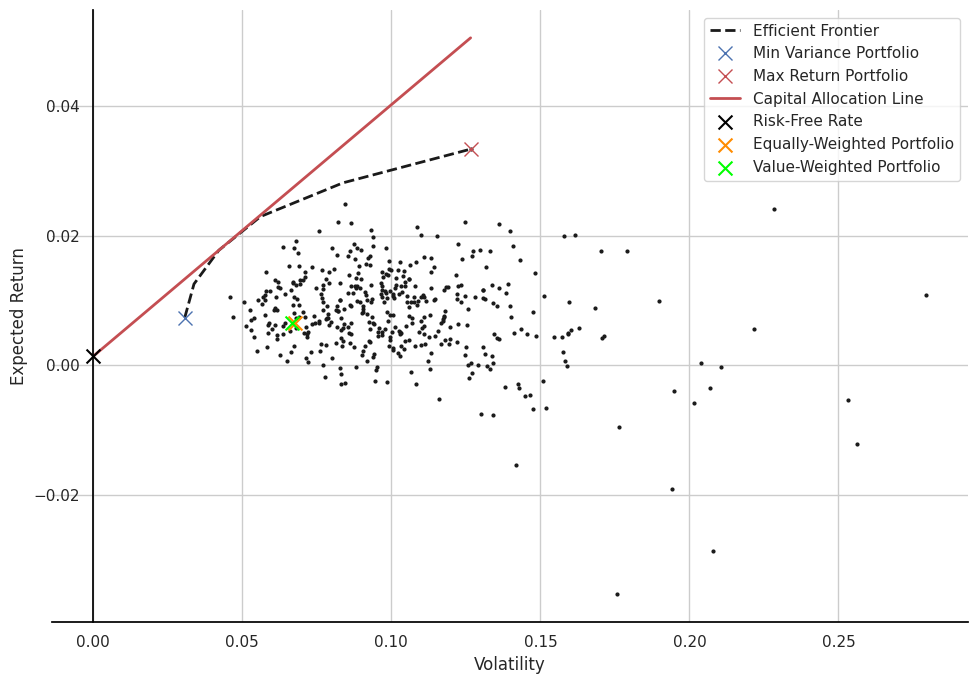

In [379]:
plt.figure(figsize=(10, 7))
#efficient frontier
plt.plot(frontier_volatilities, frontier_returns, 'k--', linewidth=2, label='Efficient Frontier')

#individual assets
for i in range(n_assets):
    plt.plot(np.sqrt(Sigma[i,i]), mu[i], 'ko', markersize=2)

#minimum variance and maximum return portfolios
plt.plot(min_var_perf["volatility"], min_var_perf["return"], 'bx', markersize=10, label='Min Variance Portfolio')
plt.plot(max_ret_perf["volatility"], max_ret_perf["return"], 'rx', markersize=10, label='Max Return Portfolio')
plt.plot(cal_volatilities, cal_returns, 'r-', linewidth=2, label='Capital Allocation Line')
plt.scatter([0], [risk_free_rate], color='black', marker='x', s=100, label='Risk-Free Rate', zorder=5)

#equally-weighted portfolio and value-weighted portfolio as a cross
plt.scatter(ew_portfolio_volatility, mean_portfolio, color='darkorange', marker='x', s=100, label='Equally-Weighted Portfolio', zorder=6)
plt.scatter(vw_portfolio_volatility, vw_portfolio_expected, color='lime', marker='x', s=100, label='Value-Weighted Portfolio', zorder=6)


#plt.title('Portfolio Optimization with Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.grid()

ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Positionner l'axe des ordonnées à la valeur 0.00 sur l'axe des abscisses
ax.spines['left'].set_color('black')
ax.spines['left'].set_position(('data', 0.00))

# Garder l'axe des abscisses au bas mais le rendre noir
ax.spines['bottom'].set_color('black')

plt.tight_layout()
#plt.savefig('/content/Frontier_fig.pdf', dpi=600)
plt.show()

### Ex-post and Ex-ante performance

#### Ex-post with 2022

In [380]:
if 'ISIN' in df_prices_month.columns:
    df_prices_month.set_index('ISIN', inplace=True)

df_prices_2022 = df_prices_month[df_prices_month.index.isin(unique_companies['ISIN'])]

df_prices_2022.columns = pd.to_datetime(df_prices_2022.columns, errors='coerce')

start_date = pd.to_datetime('2021-12-31')
end_date = pd.to_datetime('2022-12-31')

filtered_cols = df_prices_2022.columns[(df_prices_2022.columns >= start_date) & (df_prices_2022.columns <= end_date)]
df_prices_2022 = df_prices_2022[filtered_cols]

df_prices_2022 = df_prices_2022.T

def fill_with_mean(serie):
    return serie.fillna((serie.shift(1) + serie.shift(-1)) / 2)

df_prices_2022 = df_prices_2022.apply(fill_with_mean)

df_prices_2022

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2021-12-31,1111.83,724.56,5033.33,8769.64,7637.80,557.31,1433.84,1489.00,137.46,12040.64,...,2730.83,371.62,714.61,9131.77,835.22,5417.08,3360.10,11221.44,88.59,39.92
2022-01-31,1161.94,712.18,5360.04,8199.06,7445.31,572.55,1299.48,1431.24,138.39,12490.89,...,2732.32,328.59,591.03,7803.30,807.89,4542.99,2841.98,9447.87,115.14,41.32
2022-02-28,1155.92,553.64,4217.89,9458.51,6246.72,517.28,1302.88,1404.03,138.41,11718.27,...,2817.87,334.02,516.33,7750.23,771.39,4657.45,2507.38,8504.19,112.67,46.33
2022-03-31,1073.50,567.30,4277.87,8285.25,6331.35,513.52,1184.55,1331.45,137.11,10413.91,...,3288.95,334.75,532.38,8194.83,798.57,4863.37,2196.55,8565.58,128.27,52.97
2022-04-30,1044.97,482.13,4589.77,8406.71,5915.37,491.04,1041.65,1317.15,129.78,9995.25,...,3402.77,274.36,399.36,7331.20,853.40,4479.85,2209.15,7554.67,92.81,46.57
2022-05-31,1035.49,504.75,5163.58,7820.72,5895.80,498.32,1151.40,1293.70,116.96,10390.29,...,2977.25,286.86,399.24,7327.49,1096.06,4187.46,2216.31,7456.44,102.04,46.19
2022-06-30,1258.39,410.92,4341.76,7690.07,4581.59,473.30,835.35,1283.14,81.18,8606.28,...,2353.07,212.95,322.39,6307.30,1080.68,3572.61,1921.70,6222.46,91.70,35.02
2022-07-31,1229.26,409.07,3918.78,8637.53,4896.37,474.34,935.15,1203.63,81.75,9282.29,...,2370.83,230.15,357.76,7183.62,1107.06,4020.13,2046.88,7723.51,117.58,36.46
2022-08-31,1215.93,367.15,3758.17,7555.23,5022.24,493.88,847.25,1135.16,79.81,8633.47,...,2506.55,200.89,287.41,5884.82,1070.45,3546.68,1819.41,6823.05,100.69,35.64
2022-09-30,1190.06,360.26,3396.99,6751.05,4318.66,425.22,718.38,979.78,65.56,8307.13,...,2223.09,156.57,266.62,5440.40,1053.44,3250.81,1558.19,6300.71,76.18,34.45


checking there was no issue with the code before and that we kept the same datas

In [381]:
selected_row = df_prices_month.query("ISIN == 'AT0000652011'")
selected_row = selected_row.iloc[:, -14:]
selected_row

,2021-12-31 00:00:00,2022-01-31 00:00:00,2022-02-28 00:00:00,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,Country_Code
ISIN,,,,,,,,,,,,,,
AT0000652011,724.56,712.18,553.64,567.3,482.13,504.75,410.92,409.07,367.15,360.26,400.68,495.04,518.33,AT


In [382]:
df_returns = df_prices_2022.pct_change()
df_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
# Fonction pour remplir les NaN par la moyenne des valeurs avant et après
def fill_with_mean(serie):
    if serie.isna().iloc[0]:  # Conserver NaN si le premier élément est NaN
        serie.iloc[0] = np.nan
    else:
        serie.fillna((serie.shift(1) + serie.shift(-1)) / 2, inplace=True)
    return serie

# Appliquer la fonction pour chaque colonne à partir du deuxième mois
monthly_returns_2022 = df_returns.iloc[1:].apply(fill_with_mean, axis=0)

# Remplacer les valeurs dans le DataFrame original des rendements
df_returns.iloc[1:] = monthly_returns_2022
monthly_returns_2022 = monthly_returns_2022.interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')

monthly_returns_2022

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2022-01-31,0.045070,-0.017086,0.064909,-0.065063,-0.025202,0.027346,-0.093706,-0.038791,0.006766,0.037394,...,0.000546,-0.115790,-0.172933,-0.145478,-0.032722,-0.161358,-0.154198,-0.158052,0.299695,0.035070
2022-02-28,-0.005181,-0.222612,-0.213086,0.153609,-0.160986,-0.096533,0.002616,-0.019011,0.000145,-0.061855,...,0.031310,0.016525,-0.126390,-0.006801,-0.045179,0.025195,-0.117735,-0.099883,-0.021452,0.121249
2022-03-31,-0.071303,0.024673,0.014220,-0.124043,0.013548,-0.007269,-0.090822,-0.051694,-0.009392,-0.111310,...,0.167176,0.002185,0.031085,0.057366,0.035235,0.044213,-0.123966,0.007219,0.138457,0.143320
2022-04-30,-0.026577,-0.150132,0.072910,0.014660,-0.065702,-0.043776,-0.120637,-0.010740,-0.053461,-0.040202,...,0.034607,-0.180403,-0.249859,-0.105387,0.068660,-0.078859,0.005736,-0.118020,-0.276448,-0.120823
2022-05-31,-0.009072,0.046917,0.125019,-0.069705,-0.003308,0.014826,0.105362,-0.017804,-0.098783,0.039523,...,-0.125051,0.045561,-0.000300,-0.000506,0.284345,-0.065268,0.003241,-0.013003,0.099450,-0.008160
2022-06-30,0.215260,-0.185894,-0.159157,-0.016706,-0.222906,-0.050209,-0.274492,-0.008163,-0.305917,-0.171700,...,-0.209650,-0.257652,-0.192491,-0.139228,-0.014032,-0.146831,-0.132928,-0.165492,-0.101333,-0.241827
2022-07-31,-0.023149,-0.004502,-0.097421,0.123206,0.068705,0.002197,0.119471,-0.061965,0.007021,0.078548,...,0.007548,0.080770,0.109712,0.138937,0.024411,0.125264,0.065140,0.241231,0.282225,0.041119
2022-08-31,-0.010844,-0.102476,-0.040985,-0.125302,0.025707,0.041194,-0.093996,-0.056886,-0.023731,-0.069899,...,0.057246,-0.127134,-0.196640,-0.180800,-0.033070,-0.117770,-0.111130,-0.116587,-0.143647,-0.022490
2022-09-30,-0.021276,-0.018766,-0.096105,-0.106440,-0.140093,-0.139022,-0.152104,-0.136879,-0.178549,-0.037799,...,-0.113088,-0.220618,-0.072336,-0.075520,-0.015891,-0.083422,-0.143574,-0.076555,-0.243420,-0.033389
2022-10-31,0.007311,0.112197,0.259085,-0.085763,0.133224,0.093316,0.266377,0.100553,-0.034777,0.155775,...,-0.052283,0.060867,-0.071262,0.099971,0.037126,0.047419,0.177424,0.140971,0.123786,-0.068215


In [383]:
portfolio_returns = monthly_returns_2022.dot(portfolio.x)
portfolio_returns_mean = portfolio_returns.mean()
print(portfolio_returns)
print(portfolio_returns_mean)

2022-01-31   -0.124080
2022-02-28   -0.070461
2022-03-31   -0.027360
2022-04-30   -0.175479
2022-05-31   -0.002422
2022-06-30   -0.202050
2022-07-31    0.337675
2022-08-31   -0.103833
2022-09-30   -0.077670
2022-10-31    0.148522
2022-11-30    0.130967
2022-12-31   -0.041697
dtype: float64
-0.017323986527986727


In [384]:
def ex_post_performance(weights, monthly_returns, risk_free_rate):
    #weights to np array if they aren't already
    weights = np.array(weights)

    #monthly portfolio returns
    portfolio_returns = monthly_returns.dot(weights)
    portfolio_returns = portfolio_returns.replace([np.inf, -np.inf], np.nan) #if the return is "inf" replace by "Nan"

    #annualize the returns and volatility
    avg_annual_return = portfolio_returns.mean() * 12
    annual_volatility = portfolio_returns.std() * np.sqrt(12)

    #Sharpe ratio
    sharpe_ratio = (avg_annual_return - risk_free_rate) / annual_volatility

    return avg_annual_return, annual_volatility, sharpe_ratio

#ex-post performance for each portfolio
ex_post_metrics = []
for portfolio in efficient_portfolios:
    avg_return, vol, sharpe = ex_post_performance(portfolio.x, monthly_returns_2022, risk_free_rate_annual)
    ex_post_metrics.append((avg_return, vol, sharpe))

#portfolio with the highest ex-post Sharpe ratio
sharpe_ratios = [metric[2] for metric in ex_post_metrics]
max_sharpe_idx = np.argmax(sharpe_ratios)
max_sharpe_portfolio_performance = ex_post_metrics[max_sharpe_idx]

In [385]:
print(f"Expected annual return for the portfolio with the highest Sharpe ratio is {max_sharpe_portfolio_performance[0]:.4f}, volatility is {max_sharpe_portfolio_performance[1]:.4f} and the Sharpe ratio of the portfolio is {max_sharpe_portfolio_performance[2]:.4f}")

Expected annual return for the portfolio with the highest Sharpe ratio is -0.2079, volatility is 0.5335 and the Sharpe ratio of the portfolio is -0.4210


In [386]:
#Ex-post metrics for the portfolios on the efficient frontier

ex_post_metrics_results  = pd.DataFrame(ex_post_metrics, columns=['Average Annual Return', 'Annual Volatility', 'Sharpe Ratio'])
print(ex_post_metrics_results)

   Average Annual Return  Annual Volatility  Sharpe Ratio
0              -0.101092           0.185356     -0.635522
1              -0.127487           0.208840     -0.690444
2              -0.173253           0.278445     -0.682212
3              -0.268120           0.369627     -0.770576
4              -0.207008           0.466905     -0.479142
5              -0.207888           0.533515     -0.420970


#### Ex-post from 2008 to 2022

In [387]:
if 'ISIN' in df_prices_month.columns:
    df_prices_month.set_index('ISIN', inplace=True)

df_prices_2008_2022 = df_prices_month[df_prices_month.index.isin(unique_companies['ISIN'])]

df_prices_2008_2022.columns = pd.to_datetime(df_prices_2008_2022.columns, errors='coerce')

start_date = pd.to_datetime('2007-12-31')
end_date = pd.to_datetime('2022-12-31')

filtered_cols = df_prices_2008_2022.columns[(df_prices_2008_2022.columns >= start_date) & (df_prices_2008_2022.columns <= end_date)]
df_prices_2008_2022 = df_prices_2008_2022[filtered_cols]

df_prices_2008_2022 = df_prices_2008_2022.T

def fill_with_mean(serie):
    return serie.fillna((serie.shift(1) + serie.shift(-1)) / 2)

df_prices_2008_2022 = df_prices_2008_2022.apply(fill_with_mean)

df_prices_2008_2022

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2007-12-31,702.81,769.31,4132.94,3781.10,8444.76,954.66,1838.54,545.90,322.06,9427.46,...,626.52,67.19,128.62,1228.01,154.05,727.35,1104.72,1185.90,126.06,8.15
2008-01-31,675.06,581.50,3625.06,3526.82,6910.60,905.26,1542.98,492.13,297.05,8465.75,...,556.31,61.98,110.91,1066.50,140.48,601.78,1018.06,1117.07,106.75,5.80
2008-02-29,697.06,634.11,3709.12,4022.03,7420.82,998.30,1613.71,515.99,345.48,8603.67,...,583.83,72.51,109.53,1155.72,151.45,718.34,1066.58,1248.71,117.69,7.46
2008-03-31,735.97,705.71,3383.35,3859.22,8129.44,912.96,1773.02,510.09,344.53,8718.29,...,584.69,70.20,107.52,1218.89,140.73,707.92,1081.99,1359.51,125.01,6.92
2008-04-30,769.28,805.74,3847.73,4264.39,8777.25,908.79,1949.98,526.92,349.88,10007.80,...,572.49,65.41,121.24,1327.55,145.22,630.92,1052.89,1317.22,131.45,7.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,1215.93,367.15,3758.17,7555.23,5022.24,493.88,847.25,1135.16,79.81,8633.47,...,2506.55,200.89,287.41,5884.82,1070.45,3546.68,1819.41,6823.05,100.69,35.64
2022-09-30,1190.06,360.26,3396.99,6751.05,4318.66,425.22,718.38,979.78,65.56,8307.13,...,2223.09,156.57,266.62,5440.40,1053.44,3250.81,1558.19,6300.71,76.18,34.45
2022-10-31,1198.76,400.68,4277.10,6172.06,4894.01,464.90,909.74,1078.30,63.28,9601.17,...,2106.86,166.10,247.62,5984.28,1092.55,3404.96,1834.65,7188.93,85.61,32.10
2022-11-30,1248.90,495.04,4792.28,6981.93,5548.18,476.86,1119.41,1263.82,67.81,10292.14,...,2342.93,186.81,299.55,6634.13,1155.38,3817.60,2072.22,8151.37,88.01,40.12


In [388]:
df_returns_2008_2022 = df_prices_2008_2022.pct_change()
df_returns_2008_2022.replace([np.inf, -np.inf], np.nan, inplace=True)
# Fonction pour remplir les NaN par la moyenne des valeurs avant et après
def fill_with_mean(serie):
    if serie.isna().iloc[0]:  # Conserver NaN si le premier élément est NaN
        serie.iloc[0] = np.nan
    else:
        serie.fillna((serie.shift(1) + serie.shift(-1)) / 2, inplace=True)
    return serie

# Appliquer la fonction pour chaque colonne à partir du deuxième mois
monthly_returns_2008_2022 = df_returns_2008_2022.iloc[1:].apply(fill_with_mean, axis=0)

# Remplacer les valeurs dans le DataFrame original des rendements
df_returns_2008_2022.iloc[1:] = monthly_returns_2008_2022
monthly_returns_2008_2022 = monthly_returns_2008_2022.interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')

monthly_returns_2008_2022

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2008-01-31,-0.039484,-0.244128,-0.122886,-0.067250,-0.181670,-0.051746,-0.160758,-0.098498,-0.077656,-0.102012,...,-0.112063,-0.077541,-0.137692,-0.131522,-0.088088,-0.172640,-0.078445,-0.058040,-0.153181,-0.288344
2008-02-29,0.032590,0.090473,0.023189,0.140413,0.073832,0.102777,0.045840,0.048483,0.163037,0.016292,...,0.049469,0.169894,-0.012443,0.083657,0.078089,0.193692,0.047659,0.117844,0.102482,0.286207
2008-03-31,0.055820,0.112914,-0.087829,-0.040480,0.095491,-0.085485,0.098723,-0.011434,-0.002750,0.013322,...,0.001473,-0.031858,-0.018351,0.054659,-0.070782,-0.014506,0.014448,0.088732,0.062197,-0.072386
2008-04-30,0.045260,0.141744,0.137254,0.104988,0.079687,-0.004568,0.099807,0.032994,0.015528,0.147909,...,-0.020866,-0.068234,0.127604,0.089147,0.031905,-0.108769,-0.026895,-0.031107,0.051516,0.020231
2008-05-31,-0.062708,0.043389,0.114985,0.089626,-0.044973,0.014734,0.085673,0.019054,0.065680,-0.011071,...,0.063128,-0.068338,0.030930,0.046883,-0.030368,0.164427,-0.061526,0.099004,-0.017117,0.096317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-0.010844,-0.102476,-0.040985,-0.125302,0.025707,0.041194,-0.093996,-0.056886,-0.023731,-0.069899,...,0.057246,-0.127134,-0.196640,-0.180800,-0.033070,-0.117770,-0.111130,-0.116587,-0.143647,-0.022490
2022-09-30,-0.021276,-0.018766,-0.096105,-0.106440,-0.140093,-0.139022,-0.152104,-0.136879,-0.178549,-0.037799,...,-0.113088,-0.220618,-0.072336,-0.075520,-0.015891,-0.083422,-0.143574,-0.076555,-0.243420,-0.033389
2022-10-31,0.007311,0.112197,0.259085,-0.085763,0.133224,0.093316,0.266377,0.100553,-0.034777,0.155775,...,-0.052283,0.060867,-0.071262,0.099971,0.037126,0.047419,0.177424,0.140971,0.123786,-0.068215
2022-11-30,0.041827,0.235500,0.120451,0.131216,0.133667,0.025726,0.230472,0.172049,0.071587,0.071967,...,0.112048,0.124684,0.209717,0.108593,0.057508,0.121188,0.129491,0.133878,0.028034,0.249844


In [389]:
portfolio_returns_2008_2022 = monthly_returns_2008_2022.dot(portfolio.x)
portfolio_returns_2008_2022_mean = portfolio_returns_2008_2022.mean()
print(portfolio_returns_2008_2022)
print(portfolio_returns_2008_2022_mean)

2008-01-31   -0.063725
2008-02-29   -0.017605
2008-03-31   -0.190237
2008-04-30   -0.027607
2008-05-31    0.257567
                ...   
2022-08-31   -0.103833
2022-09-30   -0.077670
2022-10-31    0.148522
2022-11-30    0.130967
2022-12-31   -0.041697
Length: 180, dtype: float64
0.029415653536040903


In [390]:
#ex-post performance for each portfolio 2008-2022
ex_post_metrics_2008_2022 = []
for portfolio in efficient_portfolios:
    avg_return, vol, sharpe = ex_post_performance(portfolio.x, monthly_returns_2008_2022, risk_free_rate_annual)
    ex_post_metrics_2008_2022.append((avg_return, vol, sharpe))

#portfolio with the highest ex-post Sharpe ratio
sharpe_ratios_2008_2022 = [metric[2] for metric in ex_post_metrics_2008_2022]
max_sharpe_idx_2008_2022 = np.argmax(sharpe_ratios_2008_2022)
max_sharpe_portfolio_performance_2008_2022 = ex_post_metrics_2008_2022[max_sharpe_idx_2008_2022]

In [391]:
print(f"Expected annual return for the portfolio with the highest Sharpe ratio is {max_sharpe_portfolio_performance_2008_2022[0]:.4f}, volatility is {max_sharpe_portfolio_performance_2008_2022[1]:.4f} and the Sharpe ratio of the portfolio is {max_sharpe_portfolio_performance_2008_2022[2]:.4f}")

Expected annual return for the portfolio with the highest Sharpe ratio is 0.1794, volatility is 0.1616 and the Sharpe ratio of the portfolio is 1.0072


In [392]:
#Ex-post metrics for the portfolios on the efficient frontier

ex_post_metrics_results_2008_2022  = pd.DataFrame(ex_post_metrics_2008_2022, columns=['Average Annual Return', 'Annual Volatility', 'Sharpe Ratio'])
print(ex_post_metrics_results_2008_2022)

   Average Annual Return  Annual Volatility  Sharpe Ratio
0               0.073363           0.113243      0.500316
1               0.126992           0.126916      0.868971
2               0.179428           0.161554      1.007234
3               0.229028           0.215326      0.986054
4               0.291347           0.307294      0.893741
5               0.352988           0.445365      0.755070


#### Comparison of Ex-ante and Ex-post

In [393]:
comparison_exante_expost = pd.concat([ex_ante_metrics_results.reset_index(drop = True), ex_post_metrics_results.reset_index(drop = True)], axis = 1, keys = ['Ex-ante', 'Ex-post'])
comparison_exante_expost['Portfolio'] = range(1, len(comparison_exante_expost) + 1)
comparison_exante_expost

Ex-ante                                              Ex-post  \
  Average Annual Return Annual Volatility Sharpe Ratio Average Annual Return   
0              0.087768          0.106311     0.668437             -0.101092   
1              0.150211          0.117061     1.140477             -0.127487   
2              0.212654          0.145924     1.342807             -0.173253   
3              0.275097          0.194364     1.329416             -0.268120   
4              0.337540          0.290163     1.105702             -0.207008   
5              0.399983          0.438537     0.873990             -0.207888   

                                 Portfolio  
  Annual Volatility Sharpe Ratio            
0          0.185356    -0.635522         1  
1          0.208840    -0.690444         2  
2          0.278445    -0.682212         3  
3          0.369627    -0.770576         4  
4          0.466905    -0.479142         5  
5          0.533515    -0.420970         6

In [394]:
print("Max Sharpe Ratio (Ex-Ante):", max_sharpe_ante_portfolio_performance)
print("Max Sharpe Ratio (Ex-Post):", max_sharpe_portfolio_performance)

Max Sharpe Ratio (Ex-Ante): (0.21265388261748702, 0.14592418919151454, 1.3428074832785182)
Max Sharpe Ratio (Ex-Post): (-0.20788783833584074, 0.5335150580116269, -0.42096961340258404)


#### Comparison of ex-post and ex-ante if we include the ex-post for 2008-2022 not just 2022

In [395]:
comparison_exante_expost_version2 = pd.concat([ex_ante_metrics_results.reset_index(drop = True), ex_post_metrics_results_2008_2022.reset_index(drop = True)], axis = 1, keys = ['Ex-ante', 'Ex-post'])
comparison_exante_expost_version2['Portfolio'] = range(1, len(comparison_exante_expost_version2) + 1)
comparison_exante_expost_version2

Ex-ante                                              Ex-post  \
  Average Annual Return Annual Volatility Sharpe Ratio Average Annual Return   
0              0.087768          0.106311     0.668437              0.073363   
1              0.150211          0.117061     1.140477              0.126992   
2              0.212654          0.145924     1.342807              0.179428   
3              0.275097          0.194364     1.329416              0.229028   
4              0.337540          0.290163     1.105702              0.291347   
5              0.399983          0.438537     0.873990              0.352988   

                                 Portfolio  
  Annual Volatility Sharpe Ratio            
0          0.113243     0.500316         1  
1          0.126916     0.868971         2  
2          0.161554     1.007234         3  
3          0.215326     0.986054         4  
4          0.307294     0.893741         5  
5          0.445365     0.755070         6

### Making second frontier

In [396]:
data = {
    "Average Annual Return": [0.073363, 0.126992, 0.179428, 0.229028, 0.291347, 0.352988],
    "Annual Volatility": [0.113243, 0.126916, 0.161554, 0.215326, 0.307294, 0.445365]
}

df = pd.DataFrame(data)

df['Monthly Return'] = (1 + df['Average Annual Return'])**(1/12) - 1
df['Monthly Volatility'] = df['Annual Volatility'] / (12**0.5)
df['Sharpe Ratio'] = (df['Monthly Return'] - risk_free_rate) / df['Monthly Volatility']

df

,Average Annual Return,Annual Volatility,Monthly Return,Monthly Volatility,Sharpe Ratio
0,0.073363,0.113243,0.005917,0.032690,0.139154
1,0.126992,0.126916,0.010012,0.036637,0.235941
2,0.179428,0.161554,0.013847,0.046637,0.267586
3,0.229028,0.215326,0.017334,0.062159,0.256851
4,0.291347,0.307294,0.021536,0.088708,0.227348
5,0.352988,0.445365,0.025513,0.128566,0.187801


In [397]:
import math

adjusted_volatilities = [v * math.sqrt(12) for v in frontier_volatilities]

In [398]:
frontier_returns = ex_post_metrics_results_2008_2022['Average Annual Return']
frontier_volatilities  = ex_post_metrics_results_2008_2022['Annual Volatility']

In [399]:
#Making the Capital Allocation Line for 2008-2022



#expected return of the market portfolio
market_portfolio_2008_2022 = efficient_portfolios[max_sharpe_idx_2008_2022]
market_return_2008_2022 = frontier_returns[max_sharpe_idx_2008_2022]

market_volatility_2008_2022 = frontier_volatilities[max_sharpe_idx_2008_2022]
market_volatility_2008_2022 = market_volatility_2008_2022

slope_2008_2022 = (market_return_2008_2022 - risk_free_rate_annual) / market_volatility_2008_2022
#CAL plotting
cal_volatilities_2008_2022 = np.linspace(0, max(frontier_volatilities), 100)
cal_returns_2008_2022 = risk_free_rate_annual + slope_2008_2022 * cal_volatilities_2008_2022

annualize + modifying/creating variable for the efficient frontier

In [400]:
min_var_perf_post = df.iloc[0][['Average Annual Return', 'Annual Volatility']].to_dict()
max_ret_perf_post = df.iloc[-1][['Average Annual Return', 'Annual Volatility']].to_dict()

min_var_perf_post = {'return': min_var_perf_post['Average Annual Return'], 'volatility': min_var_perf_post['Annual Volatility']}
max_ret_perf_post = {'return': max_ret_perf_post['Average Annual Return'], 'volatility': max_ret_perf_post['Annual Volatility']}

(min_var_perf_post, max_ret_perf_post)


({'return': 0.073363, 'volatility': 0.113243},
 {'return': 0.352988, 'volatility': 0.445365})

In [401]:
min_var_perf_ante = ex_ante_metrics_results.iloc[0][['Average Annual Return', 'Annual Volatility']].to_dict()
max_ret_perf_ante = ex_ante_metrics_results.iloc[-1][['Average Annual Return', 'Annual Volatility']].to_dict()

min_var_perf_ante = {'return': min_var_perf_ante['Average Annual Return'], 'volatility': min_var_perf_ante['Annual Volatility']}
max_ret_perf_ante = {'return': max_ret_perf_ante['Average Annual Return'], 'volatility': max_ret_perf_ante['Annual Volatility']}

(min_var_perf_ante, max_ret_perf_ante)

({'return': 0.08776779549738613, 'volatility': 0.10631074125797897},
 {'return': 0.3999830122995594, 'volatility': 0.4385370647711108})

In [402]:
cal_volatilities_1 = [v * math.sqrt(12) for v in cal_volatilities]
cal_returns_1 = [v * 12 for v in cal_returns]

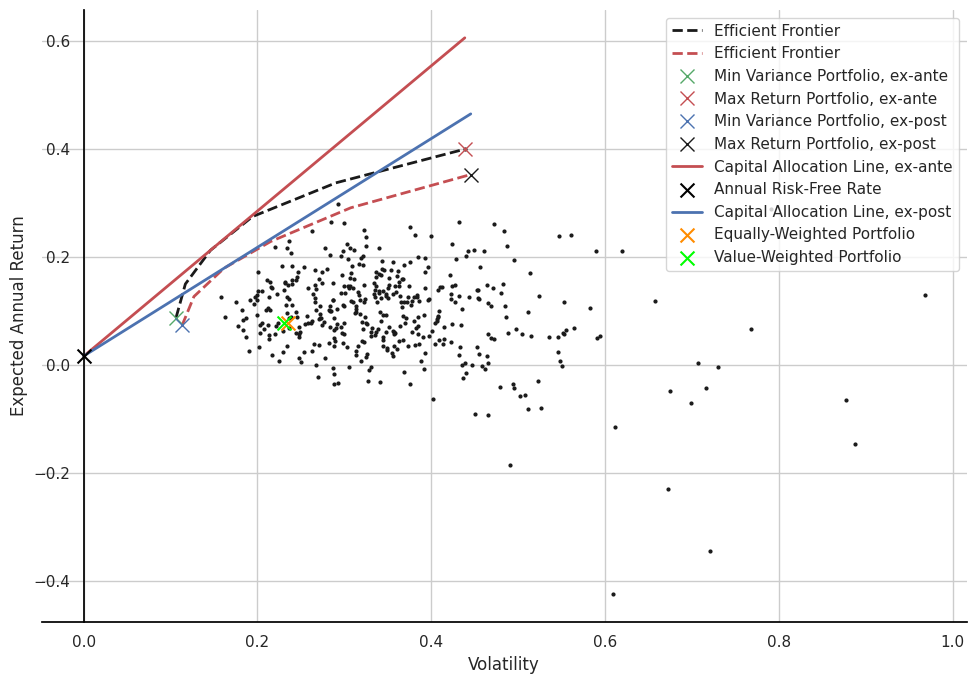

In [403]:
plt.figure(figsize=(10, 7))
#efficient frontier
plt.plot(ex_ante_metrics_results[['Annual Volatility']],ex_ante_metrics_results[['Average Annual Return']], 'k--', linewidth=2, label='Efficient Frontier')
#efficient frontier ex-post
plt.plot(df[['Annual Volatility']],df[['Average Annual Return']], 'r--', linewidth=2, label='Efficient Frontier')

#individual assets
for i in range(n_assets):
    plt.plot(np.sqrt(Sigma[i,i])* math.sqrt(12), mu[i]*12, 'ko', markersize=2)

#minimum variance and maximum return portfolios
plt.plot(min_var_perf_ante["volatility"], min_var_perf_ante["return"], 'gx', markersize=10, label='Min Variance Portfolio, ex-ante')
plt.plot(max_ret_perf_ante["volatility"], max_ret_perf_ante["return"], 'rx', markersize=10, label='Max Return Portfolio, ex-ante')

plt.plot(min_var_perf_post["volatility"], min_var_perf_post["return"], 'bx', markersize=10, label='Min Variance Portfolio, ex-post')
plt.plot(max_ret_perf_post["volatility"], max_ret_perf_post["return"], 'kx', markersize=10, label='Max Return Portfolio, ex-post')
#CAL
plt.plot(cal_volatilities_1, cal_returns_1, 'r-', linewidth=2, label='Capital Allocation Line, ex-ante')
plt.scatter([0], [risk_free_rate_annual], color='black', marker='x', s=100, label='Annual Risk-Free Rate', zorder=5)

#CAL for the ex-post
plt.plot(cal_volatilities_2008_2022, cal_returns_2008_2022, 'b-', linewidth=2, label='Capital Allocation Line, ex-post')

#equally-weighted portfolio and value-weighted portfolio as a cross
plt.scatter(ew_portfolio_volatility * math.sqrt(12), mean_portfolio*12, color='darkorange', marker='x', s=100, label='Equally-Weighted Portfolio', zorder=6)
plt.scatter(vw_portfolio_volatility * math.sqrt(12), vw_portfolio_expected*12, color='lime', marker='x', s=100, label='Value-Weighted Portfolio', zorder=6)


#plt.title('Portfolio Optimization with Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Annual Return')
plt.legend()
plt.grid()

ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Axe on 0.00
ax.spines['left'].set_color('black')
ax.spines['left'].set_position(('data', 0.00))

# Axis
ax.spines['bottom'].set_color('black')

plt.tight_layout()
#plt.savefig('/content/Frontier_fig_annualized.pdf', dpi=600)
plt.show()

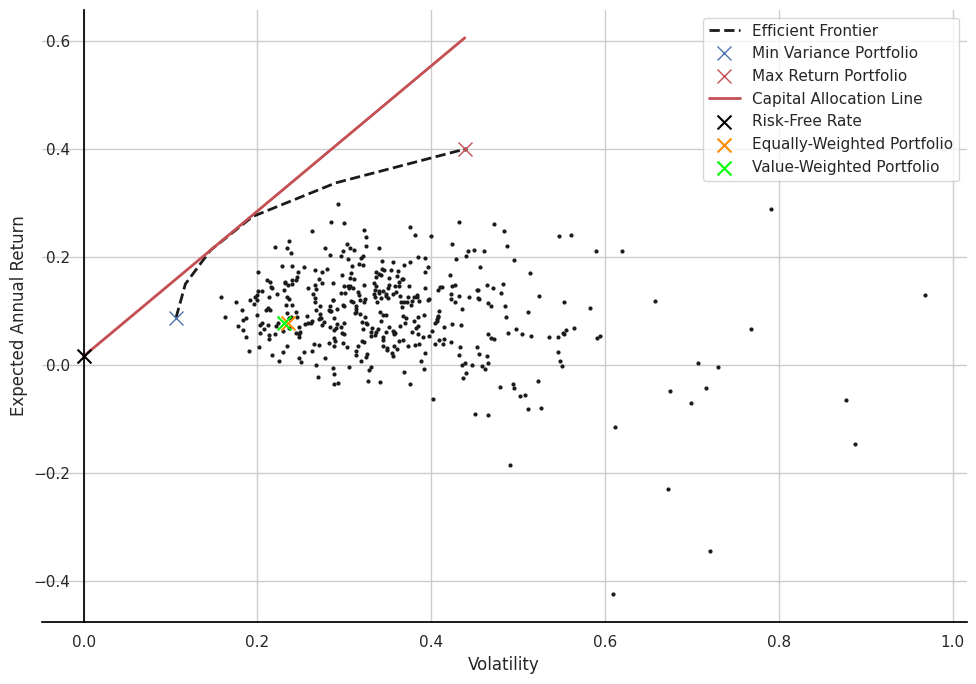

In [404]:
plt.figure(figsize=(10, 7))
#efficient frontier
plt.plot(ex_ante_metrics_results[['Annual Volatility']],ex_ante_metrics_results[['Average Annual Return']], 'k--', linewidth=2, label='Efficient Frontier')
#efficient frontier ex-post
#plt.plot(df[['Annual Volatility']],df[['Average Annual Return']], 'r--', linewidth=2, label='Efficient Frontier')

#individual assets
for i in range(n_assets):
    plt.plot(np.sqrt(Sigma[i,i])* math.sqrt(12), mu[i]*12, 'ko', markersize=2)

#minimum variance and maximum return portfolios
plt.plot(min_var_perf_ante["volatility"], min_var_perf_ante["return"], 'bx', markersize=10, label='Min Variance Portfolio')
plt.plot(max_ret_perf_ante["volatility"], max_ret_perf_ante["return"], 'rx', markersize=10, label='Max Return Portfolio')

#plt.plot(min_var_perf_post["volatility"], min_var_perf_post["return"], 'bx', markersize=10, label='Min Variance Portfolio, ex-post')
#plt.plot(max_ret_perf_post["volatility"], max_ret_perf_post["return"], 'rx', markersize=10, label='Max Return Portfolio, ex-post')
#CAL
plt.plot(cal_volatilities_1, cal_returns_1, 'r-', linewidth=2, label='Capital Allocation Line')
plt.scatter([0], [risk_free_rate_annual], color='black', marker='x', s=100, label='Risk-Free Rate', zorder=5)

#CAL for the ex-post
#plt.plot(cal_volatilities_2008_2022, cal_returns_2008_2022, 'b-', linewidth=2, label='Capital Allocation Line, ex-post')
#plt.scatter([0], [risk_free_rate], color='black', marker='x', s=100, label='Risk-Free Rate', zorder=5)

#equally-weighted portfolio and value-weighted portfolio as a cross
plt.scatter(ew_portfolio_volatility * math.sqrt(12), mean_portfolio*12, color='darkorange', marker='x', s=100, label='Equally-Weighted Portfolio', zorder=6)
plt.scatter(vw_portfolio_volatility * math.sqrt(12), vw_portfolio_expected*12, color='lime', marker='x', s=100, label='Value-Weighted Portfolio', zorder=6)


#plt.title('Portfolio Optimization with Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Annual Return')
plt.legend()
plt.grid()

ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Axe on 0.00
ax.spines['left'].set_color('black')
ax.spines['left'].set_position(('data', 0.00))

# Axis
ax.spines['bottom'].set_color('black')

plt.tight_layout()
#plt.savefig('/content/Frontier_fig_annualized.pdf', dpi=600)
plt.show()

### Showing the changes in returns from 2021-2022

In [405]:
if 'ISIN' in df_prices_month.columns:
    df_prices_month.set_index('ISIN', inplace=True)

df_prices_2021_22 = df_prices_month[df_prices_month.index.isin(unique_companies['ISIN'])]

df_prices_2021_22.columns = pd.to_datetime(df_prices_2021_22.columns, errors='coerce')

start_date = pd.to_datetime('2021-01-31')
end_date = pd.to_datetime('2022-12-31')

filtered_cols = df_prices_2021_22.columns[(df_prices_2021_22.columns >= start_date) & (df_prices_2021_22.columns <= end_date)]
df_prices_2021_22 = df_prices_2021_22[filtered_cols]

df_prices_2021_22 = df_prices_2021_22.T

def fill_with_mean(serie):
    return serie.fillna((serie.shift(1) + serie.shift(-1)) / 2)

df_prices_2021_22 = df_prices_2021_22.apply(fill_with_mean)

df_prices_2021_22

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2021-01-31,1256.98,454.11,3607.15,6973.60,6950.68,488.82,1421.68,1448.76,109.50,11671.45,...,2547.83,323.34,587.97,6257.85,797.54,4250.96,3009.10,8756.75,132.13,32.68
2021-02-28,1391.98,490.37,4135.23,5918.74,6855.57,515.02,1548.74,1597.76,104.32,12536.94,...,2450.23,301.66,556.99,6302.25,743.44,4052.22,2907.66,9193.45,127.73,39.42
2021-03-31,1263.56,503.17,4345.49,5622.04,7482.07,495.31,1613.28,1500.83,105.88,12751.31,...,2437.62,295.92,580.83,6756.57,804.49,4471.34,3457.85,9769.60,125.99,36.79
2021-04-30,1345.08,527.49,4219.37,6410.97,8012.29,511.91,1688.41,1512.68,107.82,13011.32,...,2683.86,327.06,659.93,7241.36,862.26,4657.28,3496.71,9785.41,133.46,39.57
2021-05-31,1370.62,617.37,4892.51,7150.01,8008.48,557.07,1755.68,1490.27,116.02,13983.90,...,2618.14,356.75,765.62,7922.84,973.73,4866.78,3528.16,9780.01,123.11,41.40
2021-06-30,1274.96,551.09,5040.86,7180.28,8004.35,540.34,1582.23,1579.16,116.28,13170.68,...,2569.13,351.67,803.05,7877.54,896.00,5062.14,3452.90,9882.49,117.64,39.72
2021-07-31,1220.40,582.58,4783.10,7198.31,8486.53,542.64,1737.19,1577.30,122.65,13820.96,...,2993.22,379.97,874.86,8577.53,940.62,5654.59,3265.74,10910.11,123.29,40.26
2021-08-31,1219.23,600.34,4909.00,8537.33,8149.14,570.39,1786.10,1563.18,131.69,13569.03,...,2887.10,396.71,784.57,8263.76,968.46,5908.62,3148.96,11060.64,123.60,35.97
2021-09-30,1275.83,662.51,5358.74,7925.44,7013.84,567.99,1463.13,1417.84,123.53,12925.61,...,2510.16,336.24,708.38,7499.28,920.05,5305.60,2933.81,9811.84,105.58,33.32
2021-10-31,1212.26,644.84,5373.35,8130.25,7359.14,575.12,1497.44,1460.35,128.59,12324.97,...,2521.85,375.34,785.77,7971.53,923.99,5485.98,3145.18,10430.64,99.36,36.42


In [406]:
df_returns = df_prices_2021_22.pct_change()

# Fonction pour remplir les NaN par la moyenne des valeurs avant et après
def fill_with_mean(serie):
    if serie.isna().iloc[0]:  # Conserver NaN si le premier élément est NaN
        serie.iloc[0] = np.nan
    else:
        serie.fillna((serie.shift(1) + serie.shift(-1)) / 2, inplace=True)
    return serie

# Appliquer la fonction pour chaque colonne à partir du deuxième mois
df_returns_2021_22 = df_returns.iloc[1:].apply(fill_with_mean, axis=0)

# Remplacer les valeurs dans le DataFrame original des rendements
df_returns.iloc[1:] = df_returns_2021_22
df_returns_2021_22 = df_returns_2021_22.interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')
df_returns_2021_22

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2021-02-28,0.107400,0.079848,0.146398,-0.151265,-0.013684,0.053598,0.089373,0.102847,-0.047306,0.074154,...,-0.038307,-0.067050,-0.052690,0.007095,-0.067834,-0.046752,-0.033711,0.049870,-0.033301,0.206242
2021-03-31,-0.092257,0.026103,0.050846,-0.050129,0.091386,-0.038270,0.041673,-0.060666,0.014954,0.017099,...,-0.005146,-0.019028,0.042801,0.072089,0.082118,0.103430,0.189221,0.062670,-0.013622,-0.066717
2021-04-30,0.064516,0.048334,-0.029023,0.140328,0.070865,0.033514,0.046570,0.007896,0.018323,0.020391,...,0.101017,0.105231,0.136184,0.071751,0.071809,0.041585,0.011238,0.001618,0.059290,0.075564
2021-05-31,0.018988,0.170392,0.159536,0.115277,-0.000476,0.088219,0.039842,-0.014815,0.076053,0.074749,...,-0.024487,0.090778,0.160153,0.094109,0.129277,0.044983,0.008994,-0.000552,-0.077551,0.046247
2021-06-30,-0.069793,-0.107359,0.030322,0.004234,-0.000516,-0.030032,-0.098794,0.059647,0.002241,-0.058154,...,-0.018719,-0.014240,0.048888,-0.005718,-0.079827,0.040142,-0.021331,0.010479,-0.044432,-0.040580
2021-07-31,-0.042793,0.057141,-0.051134,0.002511,0.060240,0.004257,0.097938,-0.001178,0.054782,0.049373,...,0.165071,0.080473,0.089422,0.088859,0.049799,0.117035,-0.054204,0.103984,0.048028,0.013595
2021-08-31,-0.000959,0.030485,0.026322,0.186019,-0.039756,0.051139,0.028155,-0.008952,0.073706,-0.018228,...,-0.035453,0.044056,-0.103205,-0.036580,0.029597,0.044925,-0.035759,0.013797,0.002514,-0.106557
2021-09-30,0.046423,0.103558,0.091615,-0.071672,-0.139315,-0.004208,-0.180824,-0.092977,-0.061964,-0.047418,...,-0.130560,-0.152429,-0.097111,-0.092510,-0.049987,-0.102058,-0.068324,-0.112905,-0.145793,-0.073673
2021-10-31,-0.049826,-0.026671,0.002726,0.025842,0.049231,0.012553,0.023450,0.029982,0.040962,-0.046469,...,0.004657,0.116286,0.109249,0.062973,0.004282,0.033998,0.072046,0.063067,-0.058913,0.093037
2021-11-30,-0.075124,0.037405,-0.128138,-0.001438,0.032372,-0.056249,-0.115016,-0.019345,-0.037717,-0.064059,...,0.006313,-0.015453,-0.092941,0.043278,-0.175294,-0.094731,-0.016676,-0.048094,-0.132548,-0.026634


In [407]:
df_returns_2021_22.replace([np.inf, -np.inf], np.nan, inplace=True)
df_returns_2021_22_mean = df_returns_2021_22.mean(axis=1)
df_returns_2021_22_mean

2021-02-28    0.059291
2021-03-31    0.037124
2021-04-30    0.048188
2021-05-31    0.045709
2021-06-30   -0.035426
2021-07-31    0.022056
2021-08-31    0.018627
2021-09-30   -0.049747
2021-10-31    0.023586
2021-11-30   -0.059543
2021-12-31    0.065261
2022-01-31   -0.035164
2022-02-28   -0.029025
2022-03-31   -0.005489
2022-04-30   -0.055975
2022-05-31    0.016440
2022-06-30   -0.126452
2022-07-31    0.048019
2022-08-31   -0.069363
2022-09-30   -0.112162
2022-10-31    0.082515
2022-11-30    0.107389
2022-12-31    0.009497
dtype: float64

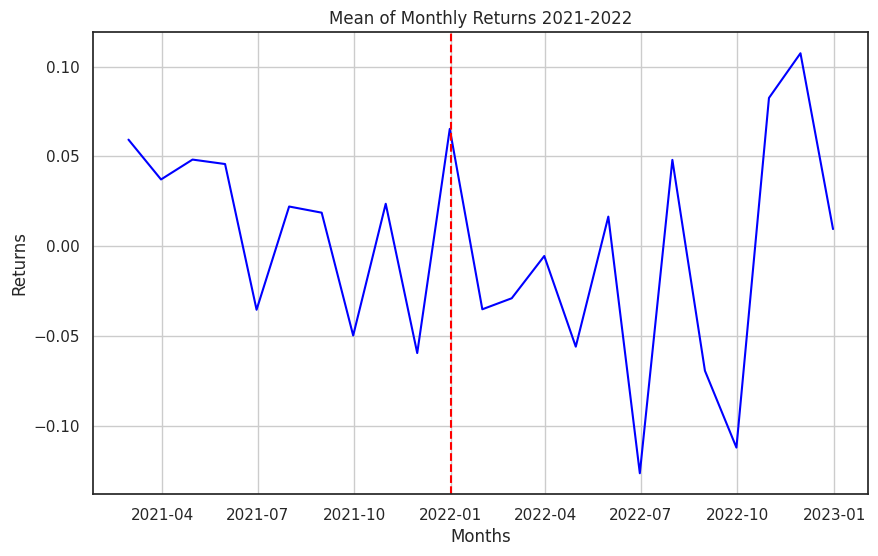

In [408]:
plt.figure(figsize=(10, 6))
plt.plot(df_returns_2021_22_mean, color='blue')
plt.title('Mean of Monthly Returns 2021-2022')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.axvline(pd.Timestamp('2022-01-01'), color='red', linestyle='--')
plt.grid(True)
plt.show()

## **Task 4**

In [409]:
import scipy.optimize as sco

In [410]:
from scipy.optimize import minimize

> **Objective:** to build the minimum variance portfolio out
of sample with an annual rebalancing

The **minimum variance portfolio** minimizes investment risks and maximizes returns. In this method, investors determine the variance to reduce the portfolio’s volatility. Therefore, to ensure minimum variance, investors diversify their investments.



The modern portfolio theory, given by Harry Markowitz, influenced the low variance approach in 1952. Markowitz was an American economist. **He stated that portfolio variance could be minimized if stocks are selected using a negative correlation.** If the correlation between assets within a portfolio is less, variance is also less ([Investopedia, 2023](https://www.investopedia.com/terms/m/modernportfoliotheory.asp))

The portfolio variance $\sigma_p^2$ is given by the quadratic form:

*$
\sigma_p^2 = \mathbf{w}^T \Sigma \mathbf{w}
$*

Where:
- $\mathbf{w}$ is the vector of portfolio weights.
- $\Sigma$ is the covariance matrix of the asset returns.
- $\mathbf{w}^T$ represents the transpose of the weights vector.

The optimization problem subject to the constraints can be written as:

$$
\begin{align*}
\text{minimize} \quad & \mathbf{w}^T \Sigma \mathbf{w} \\
\text{subject to} \quad & \sum_{i=1}^{n} w_i = 1 \\
& 0 \leq w_i \leq 1 \quad \forall i \in \{1, \ldots, n\}
\end{align*}
$$

This expresses the minimization of the portfolio variance while ensuring that all weights sum to 1 and each weight is bounded between 0 and 1, indicating the fraction of the total portfolio value invested in each asset.

### Data filtering

Based on the way we did it in task 3

In [411]:
#filtering dataset from ex.3 to get the correct dates?
if 'ISIN' in df_prices_month.columns:
    df_prices_month.set_index('ISIN', inplace=True)

df_prices_4 = df_prices_month[df_prices_month.index.isin(unique_companies['ISIN'])]

df_prices_4.columns = pd.to_datetime(df_prices_4.columns, errors='coerce')

start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2022-12-31')

filtered_cols = df_prices_4.columns[(df_prices_4.columns >= start_date) & (df_prices_4.columns <= end_date)]
df_prices_4 = df_prices_4[filtered_cols]

df_prices_4 = df_prices_4.T
df_prices_4

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2000-01-31,156.25,94.91,389.64,524.60,2379.46,161.98,154.48,111.26,130.43,3824.32,...,266.06,9.30,51.89,582.75,17.32,36.82,533.00,221.48,76.83,15.72
2000-02-29,153.83,97.74,318.75,564.59,2203.58,156.68,147.40,113.86,129.17,3886.65,...,233.04,9.69,65.40,598.76,16.79,39.76,470.45,202.18,85.51,11.76
2000-03-31,158.62,100.50,311.41,518.56,2451.55,155.74,148.80,104.32,128.94,4007.51,...,239.32,10.21,69.13,664.65,15.84,43.52,473.03,212.75,79.92,11.49
2000-04-30,137.27,96.13,335.24,463.37,2552.81,152.34,136.90,97.96,122.90,3785.57,...,202.79,11.08,59.51,619.95,16.42,40.83,432.63,209.47,80.98,8.90
2000-05-31,148.95,97.86,356.91,498.05,2746.80,159.84,132.23,100.94,128.81,3728.38,...,220.10,10.63,56.47,582.66,17.04,40.49,431.17,198.64,73.42,8.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,1215.93,367.15,3758.17,7555.23,5022.24,493.88,847.25,1135.16,79.81,8633.47,...,2506.55,200.89,287.41,5884.82,1070.45,3546.68,1819.41,6823.05,100.69,35.64
2022-09-30,1190.06,360.26,3396.99,6751.05,4318.66,425.22,718.38,979.78,65.56,8307.13,...,2223.09,156.57,266.62,5440.40,1053.44,3250.81,1558.19,6300.71,76.18,34.45
2022-10-31,1198.76,400.68,4277.10,6172.06,4894.01,464.90,909.74,1078.30,63.28,9601.17,...,2106.86,166.10,247.62,5984.28,1092.55,3404.96,1834.65,7188.93,85.61,32.10
2022-11-30,1248.90,495.04,4792.28,6981.93,5548.18,476.86,1119.41,1263.82,67.81,10292.14,...,2342.93,186.81,299.55,6634.13,1155.38,3817.60,2072.22,8151.37,88.01,40.12


In [412]:
monthly_returns_4 = df_prices_4.pct_change()
monthly_returns_4 = monthly_returns_4.dropna()
monthly_returns_4

ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
2000-02-29,-0.015488,0.029818,-0.181937,0.076230,-0.073916,-0.032720,-0.045831,0.023369,-0.009660,0.016298,...,-0.124107,0.041935,0.260358,0.027473,-0.030600,0.079848,-0.117355,-0.087141,0.112977,-0.251908
2000-03-31,0.031138,0.028238,-0.023027,-0.081528,0.112531,-0.005999,0.009498,-0.083787,-0.001781,0.031096,...,0.026948,0.053664,0.057034,0.110044,-0.056581,0.094567,0.005484,0.052280,-0.065372,-0.022959
2000-04-30,-0.134598,-0.043483,0.076523,-0.106429,0.041304,-0.021831,-0.079973,-0.060966,-0.046843,-0.055381,...,-0.152641,0.085211,-0.139158,-0.067253,0.036616,-0.061811,-0.085407,-0.015417,0.013263,-0.225413
2000-05-31,0.085088,0.017996,0.064640,0.074843,0.075991,0.049232,-0.034112,0.030421,0.048088,-0.015107,...,0.085359,-0.040614,-0.051084,-0.060150,0.037759,-0.008327,-0.003375,-0.051702,-0.093356,-0.022472
2000-06-30,0.072038,0.042918,0.021630,0.000964,0.010601,0.039414,0.087272,0.004161,0.052869,0.032009,...,-0.124307,-0.008467,-0.115637,-0.005818,0.001761,-0.063719,-0.077209,-0.126561,0.072324,-0.118391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.215260,-0.185894,-0.159157,-0.016706,-0.222906,-0.050209,-0.274492,-0.008163,-0.305917,-0.171700,...,-0.209650,-0.257652,-0.192491,-0.139228,-0.014032,-0.146831,-0.132928,-0.165492,-0.101333,-0.241827
2022-07-31,-0.023149,-0.004502,-0.097421,0.123206,0.068705,0.002197,0.119471,-0.061965,0.007021,0.078548,...,0.007548,0.080770,0.109712,0.138937,0.024411,0.125264,0.065140,0.241231,0.282225,0.041119
2022-08-31,-0.010844,-0.102476,-0.040985,-0.125302,0.025707,0.041194,-0.093996,-0.056886,-0.023731,-0.069899,...,0.057246,-0.127134,-0.196640,-0.180800,-0.033070,-0.117770,-0.111130,-0.116587,-0.143647,-0.022490
2022-09-30,-0.021276,-0.018766,-0.096105,-0.106440,-0.140093,-0.139022,-0.152104,-0.136879,-0.178549,-0.037799,...,-0.113088,-0.220618,-0.072336,-0.075520,-0.015891,-0.083422,-0.143574,-0.076555,-0.243420,-0.033389


In [413]:
monthly_returns_4_cov = monthly_returns_4.cov()
monthly_returns_4_cov

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning:

invalid value encountered in subtract



ISIN,AT00000VIE62,AT0000652011,AT0000743059,AT0000746409,AT0000831706,AT0000908504,AT0000937503,AT0000938204,AT0000A21KS2,BE0003470755,...,SE0011090018,SE0011166974,SE0015810247,SE0015811955,SE0015812219,SE0015961909,SE0016589188,SE0017486889,SE0018012494,SE0020050417
ISIN,,,,,,,,,,,,,,,,,,,,,
AT00000VIE62,0.007013,0.005521,0.004171,0.003954,0.004329,0.003966,0.004249,0.002784,0.004815,0.003244,...,0.002244,0.002917,0.003562,0.002856,0.001395,0.003596,0.003228,0.002736,0.004240,0.004067
AT0000652011,0.005521,0.013884,0.006296,0.005733,0.007561,0.006450,0.006562,0.003787,0.007748,0.006472,...,0.003476,0.004848,0.005235,0.004903,0.002786,0.006365,0.005280,0.004581,0.006217,0.007609
AT0000743059,0.004171,0.006296,0.010217,0.004510,0.004548,0.004117,0.005719,0.003159,0.006064,0.004495,...,0.002732,0.003643,0.004543,0.003209,0.001984,0.004262,0.003691,0.003467,0.004740,0.007178
AT0000746409,0.003954,0.005733,0.004510,0.008610,0.004181,0.004018,0.004474,0.002681,0.004914,0.003469,...,0.002463,0.003302,0.003868,0.003051,0.001748,0.004020,0.002642,0.002609,0.004083,0.004447
AT0000831706,0.004329,0.007561,0.004548,0.004181,0.012139,0.005234,0.006916,0.003488,0.007092,0.005612,...,0.004798,0.005637,0.005945,0.004706,0.001794,0.006382,0.005915,0.005119,0.006523,0.005786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE0015961909,0.003596,0.006365,0.004262,0.004020,0.006382,0.004232,0.006938,0.003230,0.006257,0.004979,...,0.004373,0.005535,0.006610,0.005568,0.002235,0.011900,0.006722,0.006651,0.007175,0.008419
SE0016589188,0.003228,0.005280,0.003691,0.002642,0.005915,0.003569,0.005672,0.002570,0.005051,0.004227,...,0.004085,0.004428,0.005394,0.004774,0.001652,0.006722,0.010376,0.006122,0.006255,0.007031
SE0017486889,0.002736,0.004581,0.003467,0.002609,0.005119,0.003445,0.005822,0.002496,0.004836,0.004032,...,0.004388,0.004779,0.006517,0.005136,0.001502,0.006651,0.006122,0.008591,0.006879,0.007616


### Building optimal portfolio using Markowitz’s approach

In [414]:
#This solution will give the weights for the Global Minimum Variance portfolio
#under the long-only restriction, takes only take long positions in assets (no short selling)
def portfolio_variance(weights, covariance_matrix):
    return weights.T @ covariance_matrix @ weights

def optimal_portfolio_Markowitz(covariance_matrix):
  n_assets = len(covariance_matrix)
  initial_weights = np.ones(n_assets)/n_assets
  constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
  bounds = tuple((0, 1) for asset in range(n_assets))  #we follow the constrains with the
  #total portfolio weights 1, go from 0 to 1, no negative
  result = minimize(portfolio_variance, initial_weights,
                             args=(covariance_matrix), method='SLSQP',
                             bounds=bounds, constraints=constraints)
  return result.x

In [415]:
optimal_portfolio_Markowitz(covariance_matrix)

array([2.72050122e-18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.09571940e-18, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.17162389e-18, 3.19378450e-18,
       1.99035002e-18, 1.85441058e-02, 6.45115139e-19, 4.78311590e-18,
       0.00000000e+00, 1.67855731e-01, 1.04871320e-17, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.04612875e-01, 1.68355774e-02,
       0.00000000e+00, 5.02963984e-18, 4.16884484e-02, 0.00000000e+00,
       5.08369196e-18, 0.00000000e+00, 3.11363391e-18, 1.46057388e-19,
       6.51942003e-18, 0.00000000e+00, 4.22975200e-18, 3.92574141e-18,
       2.95925007e-18, 9.66149157e-02, 0.00000000e+00, 0.00000000e+00,
       1.84221512e-18, 0.00000000e+00, 8.43475175e-20, 0.00000000e+00,
       9.88866866e-03, 7.00344441e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.93226276e-18, 5.35642506e-18,
       0.00000000e+00, 0.00000000e+00, 6.08148056e-18, 7.83790711e-18,
      

### Rolling window function

In [416]:
n_assets

426

In [417]:
risk_free_rate_annual

0.016705789379771036

In [273]:
#We start with the rolling window approach
start_year = 2008
end_year = 2020
rolling_window = 8
weights_rolling = {}
portfolio_monthly_returns_after_rebalancing = []

optimal_weights = np.ones(n_assets) / n_assets #I do not define n_assets again because it was defined earlier in the code
#kind of same weights for each asset, we have n_assets 426

for year_end in range(start_year, end_year + 1):
    #this is our start and the end of the rolling window
    start_period = f'{year_end - rolling_window}-12'
    end_period = f'{year_end}-12'

    # Get returns within the rolling window and calculate the covariance matrix
    window_returns = monthly_returns_4.loc[start_period:end_period]
    covariance_matrix = window_returns.cov().values

    #so we need to optimase on each step
    optimal_weights = optimal_portfolio_Markowitz(covariance_matrix) #our optimisation function for Matzkovich from the previous step
    #optimal_weights = np.expand_dims(optimal_weights, 0)
    weights_rolling[end_period] = optimal_weights

    # Calculate monthly portfolio returns for the next year and rebalance the portfolio weights
    for month in range(1, 13):
        next_month = pd.to_datetime(f'{year_end + 1}-{month:02d}').strftime('%Y-%m')
        if next_month not in monthly_returns_4.index:
            continue
        #month_returns = monthly_returns_4.loc[next_month].values#.flatten() ##### used correct monthly_returns for the task
        #portfolio_return = np.dot(optimal_weights, month_returns)
        month_returns = monthly_returns_4.loc[next_month].squeeze()#.to_numpy() #to handle the problem with different shapes
        #month_returns = np.expand_dims(month_returns, 0)
        portfolio_return = np.dot(optimal_weights, month_returns)
        portfolio_monthly_returns_after_rebalancing.append(portfolio_return)

        #we update the weights on each of our step
        optimal_weights = optimal_weights * (1 + month_returns) / (1 + portfolio_return)
        optimal_weights /= np.sum(optimal_weights)

#just converting the results into the dataframe for the future reporting
df_weights_rolling = pd.DataFrame(weights_rolling).T
monthly_returns_rebalancing_total = pd.Series(portfolio_monthly_returns_after_rebalancing, name='Portfolio_Return')

#essential metric which we need to compute, same as in the tasks before
annualized_return = np.mean(monthly_returns_rebalancing_total) * 12
annualized_volatility = np.std(monthly_returns_rebalancing_total) * np.sqrt(12)
sharpe_ratio = (annualized_return - risk_free_rate_annual) / annualized_volatility ## CHANGED TO THE RISK-FREE RATE TO ANNUAL
min_return = np.min(monthly_returns_rebalancing_total)
max_return = np.max(monthly_returns_rebalancing_total)

#same as we did before
performance_metrics = {
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_volatility,
    'Minimum Return': min_return,
    'Maximum Return': max_return,
    'Sharpe Ratio': sharpe_ratio
}

performance_metrics

{'Annualized Return': 0.08795295217756141,
 'Annualized Volatility': 0.12468018362593498,
 'Minimum Return': -0.08905085674910035,
 'Maximum Return': 0.10807812682206255,
 'Sharpe Ratio': 0.571439347663666}

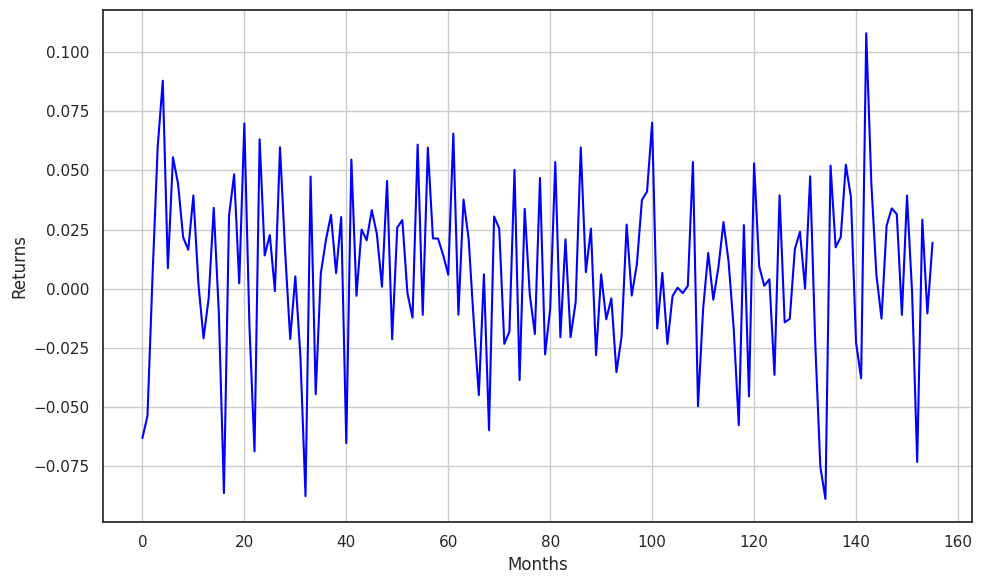

In [274]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_returns_rebalancing_total, color='blue')
#plt.title('Monthly Returns with Rolling Window (Rebalancing)')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.grid(True)
plt.tight_layout()
#plt.savefig('/content/monthly_returns_rebalancing_total', dpi=600)
plt.show()

In [275]:
df_weights_rolling

,0,1,2,3,4,5,6,7,8,9,...,416,417,418,419,420,421,422,423,424,425
2008-12,0.000000e+00,5.434063e-18,0.000000e+00,2.157312e-18,0.000000e+00,6.416169e-19,0.000000e+00,1.036403e-18,1.486109e-18,4.861609e-18,...,0.000000e+00,0.000000e+00,0.000000e+00,9.170883e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.191166e-19,6.140977e-19
2009-12,0.000000e+00,1.273502e-19,0.000000e+00,0.000000e+00,4.217155e-18,0.000000e+00,0.000000e+00,6.661938e-18,2.067894e-18,0.000000e+00,...,0.000000e+00,7.496784e-19,3.660690e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.504396e-18,3.522609e-18,3.527766e-18
2010-12,6.682329e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.317055e-17,3.728190e-19,...,1.781692e-18,2.302894e-18,0.000000e+00,0.000000e+00,5.036452e-05,0.000000e+00,0.000000e+00,0.000000e+00,2.998120e-18,3.759679e-18
2011-12,4.530308e-18,6.788741e-18,4.232690e-18,4.347409e-18,5.897866e-19,0.000000e+00,0.000000e+00,8.851733e-19,9.072460e-18,0.000000e+00,...,0.000000e+00,4.566179e-18,9.014046e-19,1.527626e-18,6.525023e-03,3.410434e-18,3.105577e-19,1.574018e-18,7.473015e-19,4.271117e-18
2012-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.785543e-18,...,6.117905e-19,7.142476e-19,2.912094e-18,3.429055e-19,7.951855e-04,0.000000e+00,0.000000e+00,0.000000e+00,1.863808e-19,0.000000e+00
2013-12,0.000000e+00,3.057933e-18,1.027798e-17,2.613866e-18,0.000000e+00,2.828898e-18,4.025472e-18,0.000000e+00,1.198786e-18,9.849158e-19,...,1.523274e-18,0.000000e+00,0.000000e+00,3.823647e-19,0.000000e+00,5.632083e-18,2.575980e-19,1.010131e-18,0.000000e+00,0.000000e+00
2014-12,0.000000e+00,0.000000e+00,4.606726e-18,0.000000e+00,0.000000e+00,4.187350e-19,0.000000e+00,3.908530e-18,2.818115e-18,3.907691e-18,...,1.995418e-18,6.203065e-18,0.000000e+00,0.000000e+00,2.468769e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.829711e-18
2015-12,0.000000e+00,2.852854e-18,1.149446e-18,0.000000e+00,1.403818e-18,9.075229e-18,6.182145e-18,2.796573e-18,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,5.758958e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2016-12,4.062599e-18,0.000000e+00,3.162209e-18,2.473786e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.568962e-19,...,0.000000e+00,5.755029e-20,3.115258e-19,0.000000e+00,0.000000e+00,1.913126e-18,0.000000e+00,1.307954e-18,1.432936e-19,1.893725e-18
2017-12,0.000000e+00,0.000000e+00,2.018461e-18,0.000000e+00,0.000000e+00,4.510065e-18,0.000000e+00,0.000000e+00,5.001416e-18,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.327136e-18,1.020092e-18,8.223660e-19,1.847319e-19,8.837989e-19,0.000000e+00,1.656589e-18


In [276]:
df_weights_rolling_reduced = df_weights_rolling.iloc[:5, :5]
df_weights_rolling_reduced

tex_file_path = '/content/df_weights_rolling.tex'
df_weights_rolling_reduced.to_latex(tex_file_path, index=True)
tex_file_path


<ipython-input-276-81d16a4d779f>:5: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



'/content/df_weights_rolling.tex'

In [277]:
df_weights_rolling.describe()

,0,1,2,3,4,5,6,7,8,9,...,416,417,418,419,420,421,422,423,424,425
count,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,...,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01
mean,1.379054e-18,1.711232e-18,2.166080e-18,7.204589e-19,6.322482e-19,1.536247e-18,8.446943e-19,5.251547e-05,3.824749e-18,1.483948e-18,...,6.125441e-19,1.402269e-18,6.432008e-19,5.388527e-19,5.669672e-04,1.021544e-18,1.092960e-19,5.889896e-19,6.243709e-19,1.712965e-18
std,2.309297e-18,2.332486e-18,2.979472e-18,1.405337e-18,1.256327e-18,2.690148e-18,1.949017e-18,1.893472e-04,6.415873e-18,1.976923e-18,...,7.798902e-19,2.108787e-18,1.216004e-18,8.018182e-19,1.803513e-03,1.741115e-18,2.016200e-19,8.087290e-19,1.197664e-18,1.994033e-18
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.273502e-19,1.149446e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.036403e-18,1.486109e-18,3.728190e-19,...,0.000000e+00,5.755029e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.496354e-20,0.000000e+00,6.140977e-19
75%,2.652462e-18,3.057933e-18,3.162209e-18,2.473786e-19,5.897866e-19,2.496669e-18,1.247922e-19,4.655218e-18,4.906410e-18,3.785543e-18,...,1.359076e-18,2.302894e-18,5.758958e-19,9.170883e-19,2.468769e-18,1.502060e-18,1.847319e-19,1.010131e-18,5.191166e-19,3.527766e-18
max,6.682329e-18,6.788741e-18,1.027798e-17,4.347409e-18,4.217155e-18,9.075229e-18,6.182145e-18,6.827011e-04,2.317055e-17,4.861609e-18,...,1.995418e-18,6.203065e-18,3.660690e-18,2.507965e-18,6.525023e-03,5.632083e-18,6.679609e-19,2.504396e-18,3.522609e-18,5.829711e-18


### Comparison to the benchmark

In [278]:
ew_vw__rolling_stats_combined = pd.DataFrame({
    'Statistic': ['Annualized Return', 'Annualized Volatility', 'Min Return', 'Max Return', 'Sharpe Ratio'],
    'Equally Weighed Portfolio': ew_stats,
    'Value Weighed Portfolio': vw_stats,
    'Rolling Window Portfolio': list(performance_metrics.values())})

In [279]:
ew_vw__rolling_stats_combined

,Statistic,Equally Weighed Portfolio,Value Weighed Portfolio,Rolling Window Portfolio
0,Annualized Return,0.078125,0.078371,0.087953
1,Annualized Volatility,0.235019,0.230592,0.124680
2,Min Return,-0.265958,-0.246441,-0.089051
3,Max Return,0.257990,0.252397,0.108078
4,Sharpe Ratio,0.326599,0.333937,0.571439
